In [3]:
import os 
from scipy.interpolate import interp1d
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [4]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob
from itertools import combinations_with_replacement

In [5]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [53]:
def calcRbir_cv(data, fold=5, rescale=True):
    fold = int(fold)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    yave = np.mean(y)
    ystd = np.std(y)
    y = (y-yave)/ystd
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        #print(np.shape(weights[:, i]))
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20), norm=True):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    
    if norm:
        ymean = np.mean(data['Rbir'].dropna())
        ystd = np.std(data['Rbir'].dropna())

        data['Rbir_norm'] = normalize_data(data['Rbir'])
        data['R_norm'] = normalize_data(data['R'])
        
    for i in range(len(Rbirbin)-1):
        
        if norm:
            data_loc = data.loc[(data['Rbir_norm']>Rbirbin[i])&(data['Rbir_norm']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = np.std(data_loc['R_norm']-data_loc['Rbir_norm'])
        else:
            data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
            
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def predNew(weights, data, rescale=True):
    weights = np.array(weights)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
        
    X = list(args)
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)
    X = np.array(X).T
    y = normalize_data(data['Rbir'].values)
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
    y_predict = np.dot(weights.T, A.T)
    return y, y_predict


In [95]:
outall = pd.read_pickle('weights_disk.pkl')
outall

names      w755  w_err755      w708  w_err708      w826  \
0                   $θ_C$ -0.000036  0.000085  0.000010  0.000141  0.000009   
1            $θ_{[Fe/H]}$ -1.491121  0.011161 -1.948036  0.009783 -1.254904   
2                 $θ_{τ}$ -1.021805  0.007349 -1.686517  0.009260 -1.030159   
3          $θ_{[Fe/H]^2}$ -0.079354  0.092532  0.066790  0.063953  0.030292   
4           $θ_{[Fe/H]τ}$  0.679710  0.040846  1.092440  0.055339  0.903222   
5               $θ_{τ^2}$ -0.327850  0.013307 -0.372458  0.020365 -0.325368   
6                 scatter  0.486808  0.000000  0.772801  0.000000  0.624235   
7                    bias  0.000036  0.000000 -0.000010  0.000000 -0.000009   
8            scatter_pred  0.832959  0.000000  1.005785  0.000000  0.870757   
9               bias_pred  0.000044  0.000000 -0.000012  0.000000 -0.000011   
10  mean $σ_{rm}-σ_{inf}$  0.398634  0.000000  0.066851  0.000000  0.276546   

    w_err826          w279  w_err279      w696  w_err696  
0   0.000204  1.121136e-07  0.000145  0.000002  0.000779  
1   0.001975 -1.212199e+00  0.000664 -3.023371  0.003037  
2   0.001371 -9.071606e-01  0.000511 -2.560400  0.002614  
3   0.026420  7.837795e-02  0.003304 -0.276004  0.012508  
4   0.004153  6.775926e-01  0.002688  0.744389  0.021501  
5   0.001379 -3.343412e-01  0.000866  0.101508  0.010070  
6   0.000000  5.239417e-01  0.000000  1.539722  0.000000  
7   0.000000 -1.121133e-07  0.000000 -0.000002  0.000000  
8   0.000000  8.144551e-01  0.000000  1.727578  0.000000  
9   0.000000 -1.401419e-07  0.000000 -0.000002  0.000000  
10  0.000000  4.637641e-01  0.000000 -0.914340  0.000000

/tmp/ipykernel_3420507/2158595129.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
/tmp/ipykernel_3420507/2158595129.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))


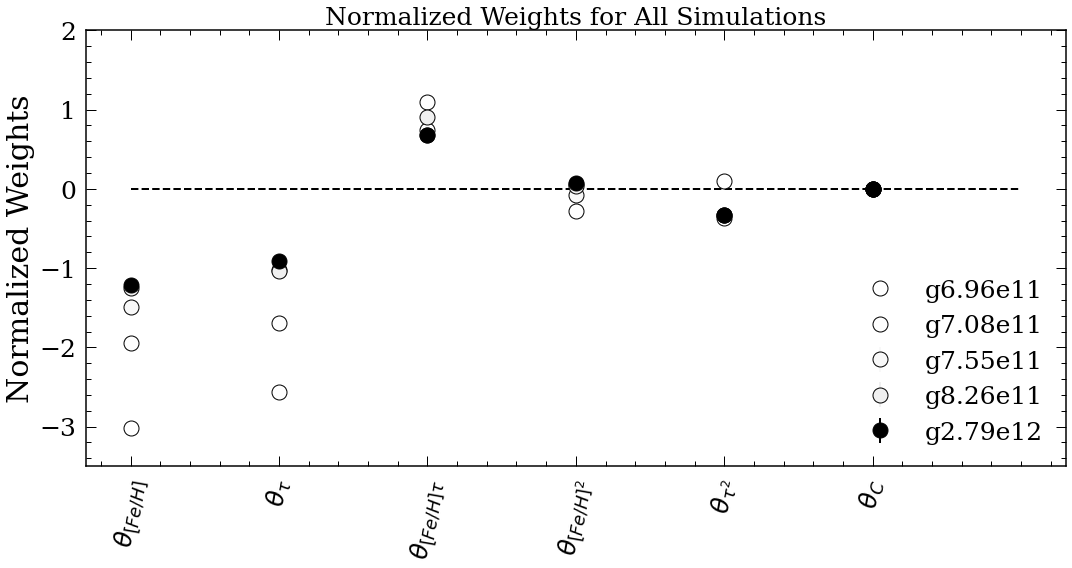

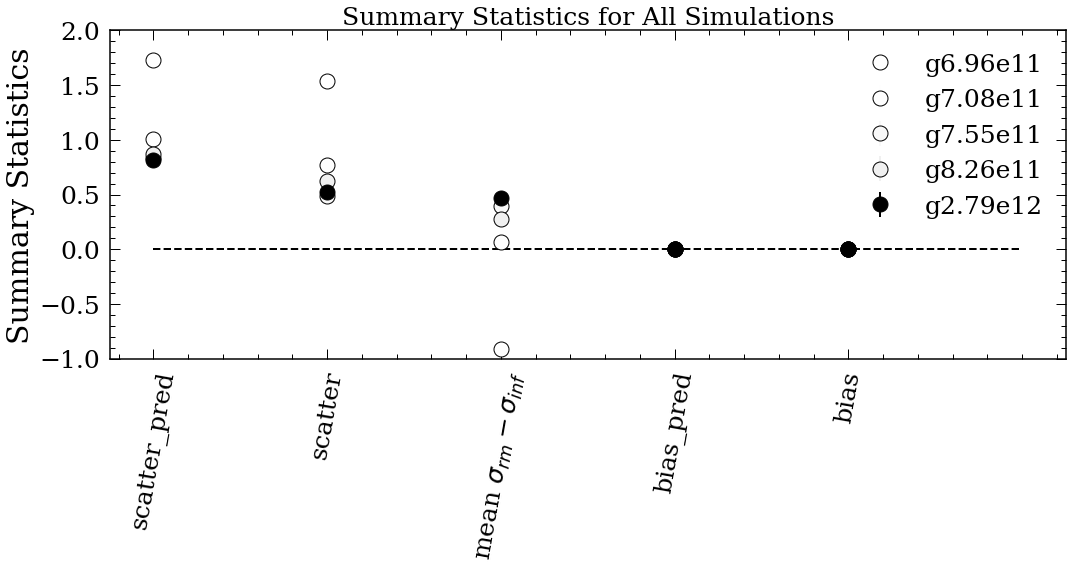

In [96]:
import matplotlib
def getcolor(vrange,cm=plt.cm.get_cmap('binary')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]

bulgemass = sorted(np.array(simsnames, dtype=float))
colors = getcolor(bulgemass)


outall_w = outall.loc[outall['names'].isin(['$θ_{[Fe/H]}$','$θ_{τ}$','$θ_{[Fe/H]τ}$',
                                            '$θ_{R_g}$','$θ_{τ^2}$','$θ_{[Fe/H]^2}$',
                                            '$θ_{R_g^2}$', '$θ_{R_gτ}$',
                                            '$θ_{[Fe/H]R_g}$','$θ_C$'])]
outall_s = outall.loc[outall['names'].isin(['scatter','bias','scatter_pred',
                                            'bias_pred','mean $σ_{rm}-σ_{inf}$'])]

outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
outall_w = outall_w.sort_values(by='absw696').reset_index(drop=True)
outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))
outall_s = outall_s.sort_values(by='absw696').reset_index(drop=True)


        
plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_w)), outall_w['w696'], yerr=outall_w['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w708'], yerr=outall_w['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w755'], yerr=outall_w['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w826'], yerr=outall_w['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w279'], yerr=outall_w['w_err279'], color=colors[4],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_w)],[0,0],'k--')
plt.ylim([-3.5,2])
plt.xticks(range(len(outall_w)), outall_w['names'], rotation=80)
plt.title('Normalized Weights for All Simulations', fontsize=25)
plt.legend(loc=4)
plt.ylabel('Normalized Weights')
plt.tight_layout()


plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_s)), outall_s['w696'], yerr=outall_s['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w708'], yerr=outall_s['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w755'], yerr=outall_s['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w826'], yerr=outall_s['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w279'], yerr=outall_s['w_err279'], color=colors[4],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_s)],[0,0],'k--')
plt.ylim([-1,2])
plt.xticks(range(len(outall_s)), outall_s['names'], rotation=80)
plt.title('Summary Statistics for All Simulations', fontsize=25)
plt.legend(loc=1)
plt.ylabel('Summary Statistics')
plt.tight_layout()



In [16]:
dmmass = np.zeros(5)
gasmass = np.zeros(5)
starsmass = np.zeros(5)

simsnames = [i for i in simsnames if '1.12e12' not in i]

for i in range(len(simsnames)):
    print(simsnames[i])
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}
    snap = snaplookup[max(allsnaps_time)]

    print(snap)
    s = pb.load(snap)

    h=s.halos()
    pb.analysis.angmom.faceon(h[1])
    s.physical_units()

    gal = pb.filt.LowPass('r', '25 kpc') & pb.filt.BandPass('z', '-2.5 kpc', '2.5 kpc')
    sim = h[1][gal]
    
    stars = sim.s
    gas = sim.g
    dm = sim.dm
    
    dmmass[i], gasmass[i], starsmass[i] = sum(dm['mass']), sum(gas['mass']), sum(stars['mass'])
    
    print(simsnames[i], sum(dm['mass']), sum(gas['mass']), sum(stars['mass']))
    
    



6.96e11
g6.96e11_3x9/6.96e11.01024
6.96e11 36919577628.69748 13376037374.789814 13553628244.330439
8.26e11
g8.26e11_2x4x8/8.26e11.02000
8.26e11 60835454496.74375 17876063738.412292 30840817778.725582
7.08e11
g7.08e11_5x10/7.08e11.01024
7.08e11 44864835726.21481 11580735029.809793 18607874995.395233
2.79e12
g1.12e12_3x9/1.12e12.02000
2.79e12 67480412910.366394 3841407783.367182 58833517319.17724
7.55e11
g2.79e12_3x6/2.79e12.02000
7.55e11 107886230767.45177 46603869579.23346 137991195697.68173


In [20]:
barA = [0.02279401670499593, 0.012171388618551002, 0.016795018960490203, 0.04611144765042728, 0.0165365810085131]
bulgemass = [float(i) for i in simsnames]

df_sum = pd.DataFrame(np.array((simsnames, bulgemass, dmmass, gasmass, starsmass, barA)).T, 
                  columns=['simname',  'bulgemass', 'dm_mass', 'gasmass', 'starmass', 'baramp'])



In [43]:
for i in df_sum.columns:
    if i=='simname':
        continue
    df_sum[i] = np.array(df_sum[i], dtype=float)

In [71]:
df_sum['totmass']=df_sum['dm_mass']+df_sum['gasmass']+df_sum['starmass']
df_sum['gasfrac']=df_sum['gasmass']/df_sum['totmass']
df_sum['starfrac']=df_sum['starmass']/df_sum['totmass']
df_sum['dmfrac']=df_sum['dm_mass']/df_sum['totmass']
df_sum['stargas']=df_sum['starmass']/df_sum['gasmass']


In [44]:
sum_dic = {'6.96e11':'w696', '8.26e11':'w826', '7.08e11':'w708', '2.79e12':'w279', '7.55e11':'w755'}
sum_dic_err = {'6.96e11':'w_err696', '8.26e11':'w_err826', '7.08e11':'w_err708', 
               '2.79e12':'w_err279', '7.55e11':'w_err755'}



In [97]:
outall = outall.sort_values(by='w755').reset_index(drop=True)

In [101]:
outall

names      w755  w_err755      w708  w_err708      w826  \
0            $θ_{[Fe/H]}$ -1.491121  0.011161 -1.948036  0.009783 -1.254904   
1                 $θ_{τ}$ -1.021805  0.007349 -1.686517  0.009260 -1.030159   
2               $θ_{τ^2}$ -0.327850  0.013307 -0.372458  0.020365 -0.325368   
3          $θ_{[Fe/H]^2}$ -0.079354  0.092532  0.066790  0.063953  0.030292   
4                   $θ_C$ -0.000036  0.000085  0.000010  0.000141  0.000009   
5                    bias  0.000036  0.000000 -0.000010  0.000000 -0.000009   
6               bias_pred  0.000044  0.000000 -0.000012  0.000000 -0.000011   
7   mean $σ_{rm}-σ_{inf}$  0.398634  0.000000  0.066851  0.000000  0.276546   
8                 scatter  0.486808  0.000000  0.772801  0.000000  0.624235   
9           $θ_{[Fe/H]τ}$  0.679710  0.040846  1.092440  0.055339  0.903222   
10           scatter_pred  0.832959  0.000000  1.005785  0.000000  0.870757   

    w_err826          w279  w_err279      w696  w_err696  
0   0.001975 -1.212199e+00  0.000664 -3.023371  0.003037  
1   0.001371 -9.071606e-01  0.000511 -2.560400  0.002614  
2   0.001379 -3.343412e-01  0.000866  0.101508  0.010070  
3   0.026420  7.837795e-02  0.003304 -0.276004  0.012508  
4   0.000204  1.121136e-07  0.000145  0.000002  0.000779  
5   0.000000 -1.121133e-07  0.000000 -0.000002  0.000000  
6   0.000000 -1.401419e-07  0.000000 -0.000002  0.000000  
7   0.000000  4.637641e-01  0.000000 -0.914340  0.000000  
8   0.000000  5.239417e-01  0.000000  1.539722  0.000000  
9   0.004153  6.775926e-01  0.002688  0.744389  0.021501  
10  0.000000  8.144551e-01  0.000000  1.727578  0.000000

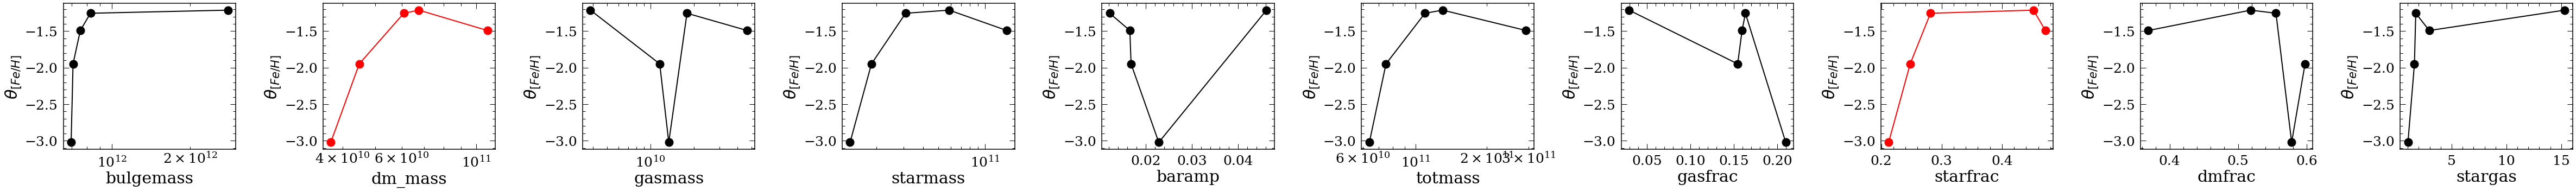

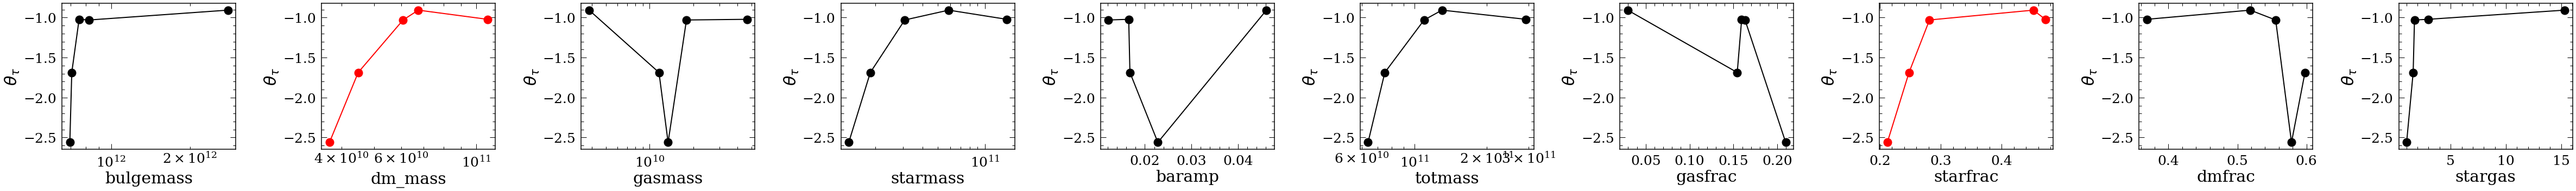

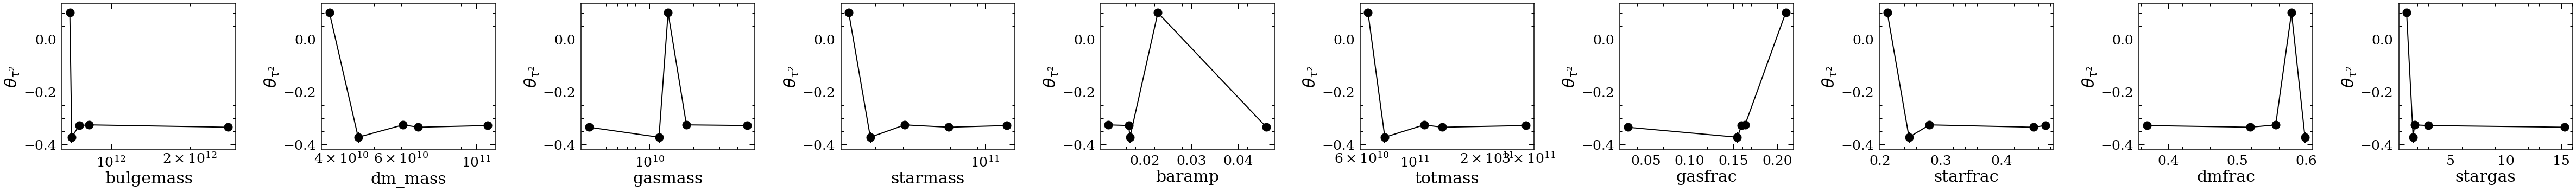

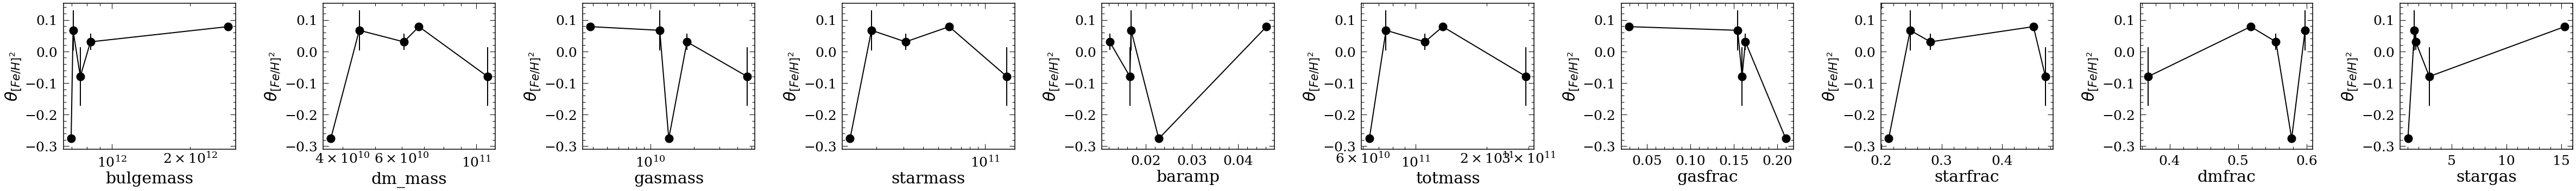

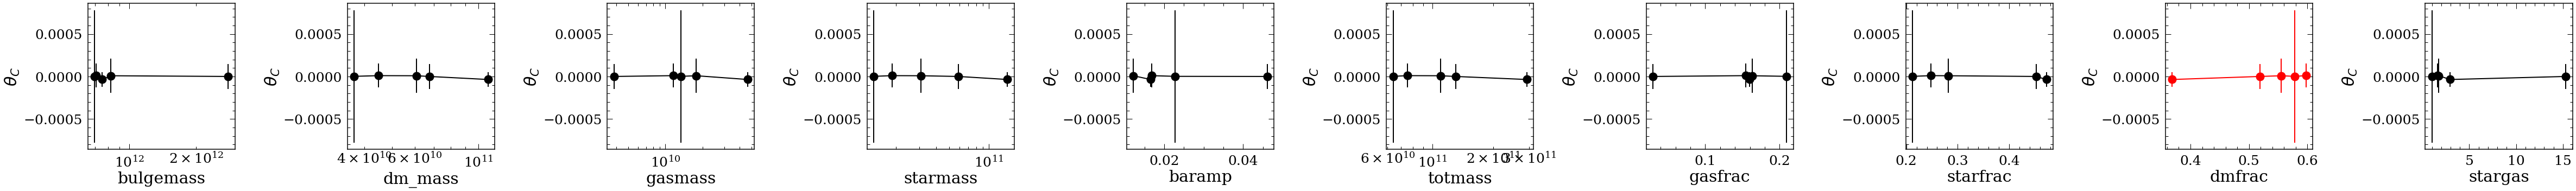

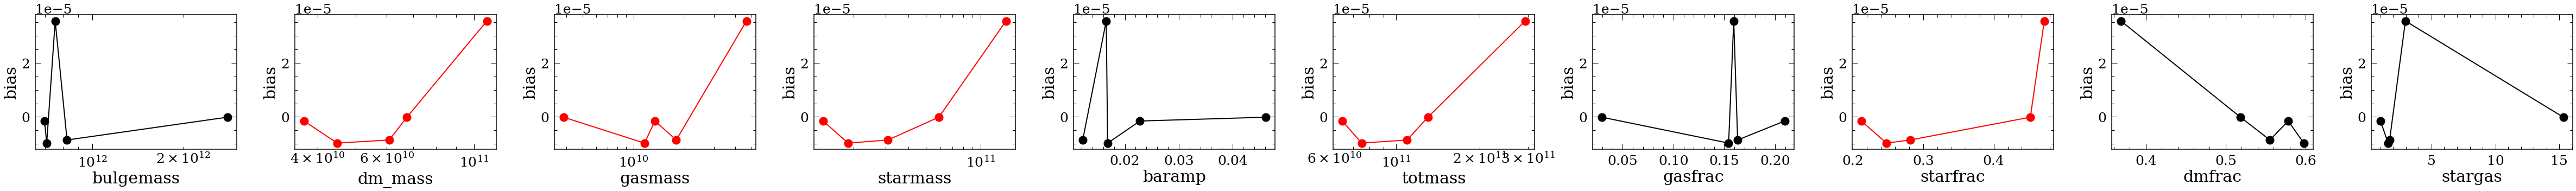

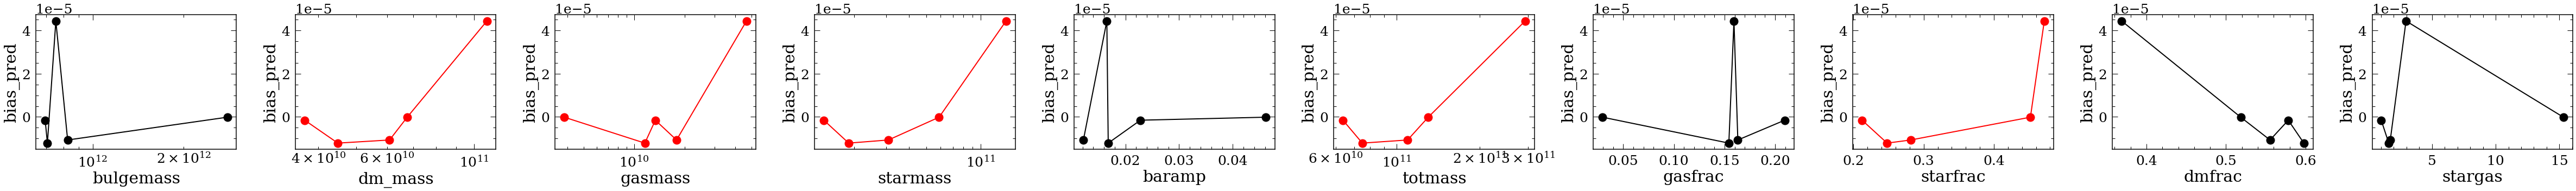

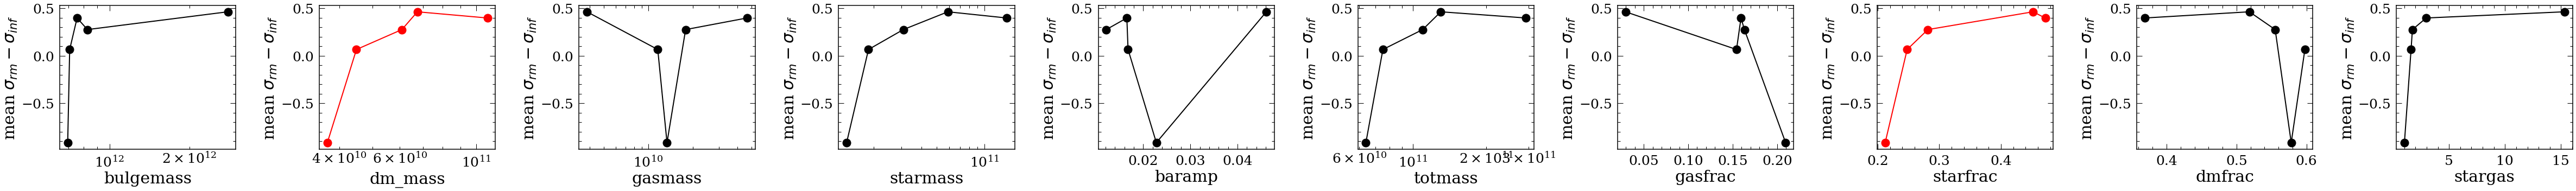

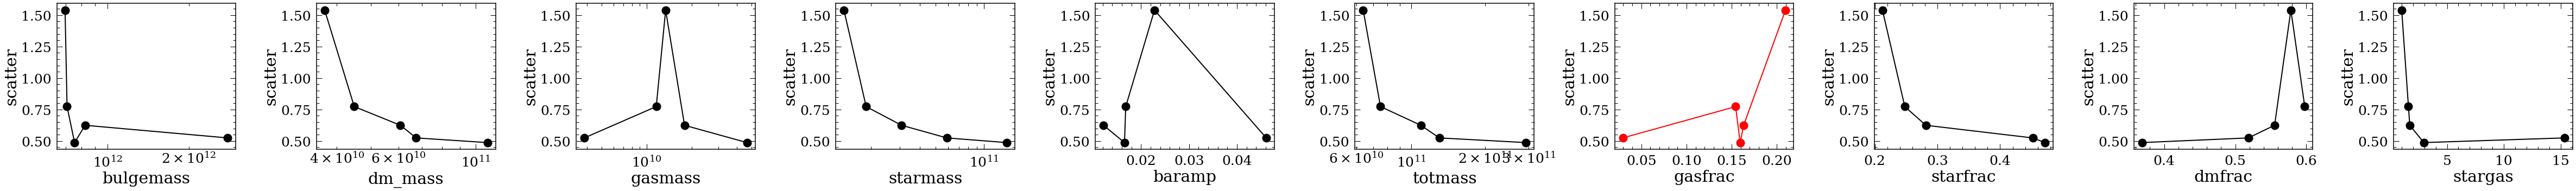

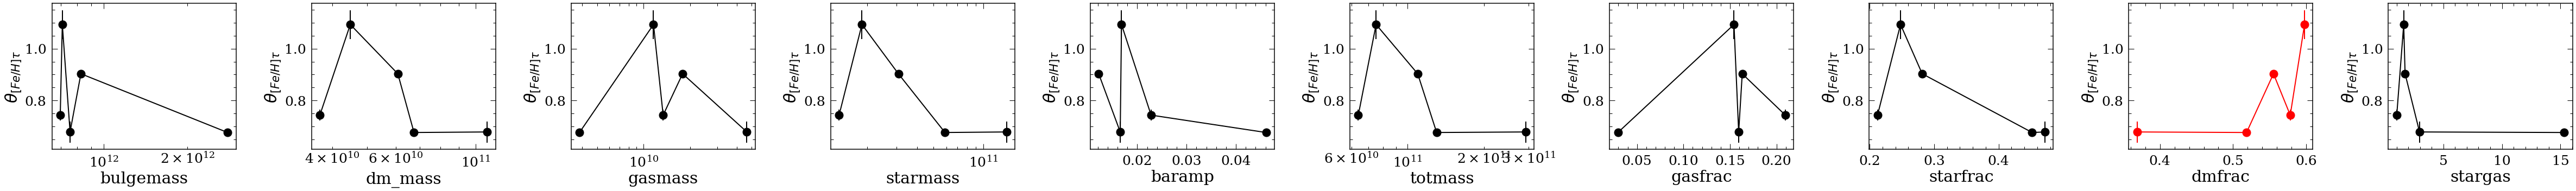

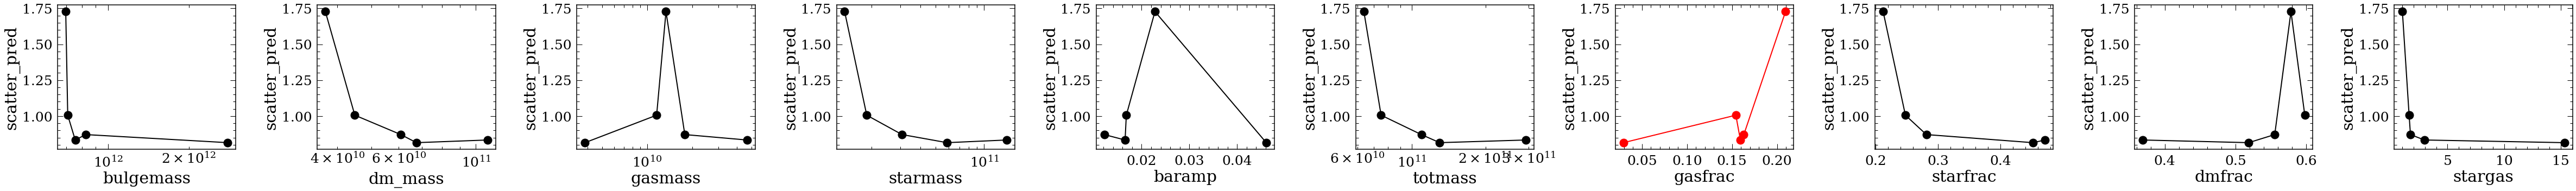

In [102]:
pcthread = 0.6
cols_out = outall['names'].values
sums_out = df_sum.columns

for i in range(len(outall['names'])):
    plt.figure(figsize=(len(sums_out)*6,5))
    df_sing = outall.loc[outall['names']==cols_out[i]]
    #print(df_sing)
    # go into each physical properties
    for j in range(len(sums_out)-1):
        plt.subplot(1,len(sums_out)-1,j+1)
        sum_sing = df_sum[['simname',sums_out[j+1]]]
        # plot the actual plot
        xs = np.zeros(5)
        ys = np.zeros(5)
        ys_err = np.zeros(5)
        for k in range(5):
            xs[k] = sum_sing.loc[sum_sing['simname']==simsnames[k]][sums_out[j+1]]
            ys[k] = df_sing[sum_dic[simsnames[k]]]
            ys_err[k] = df_sing[sum_dic_err[simsnames[k]]]
        xs, ys, ys_err = zip(*sorted(zip(xs, ys, ys_err)))
        pc = np.corrcoef(xs, ys)[0][1]
        if pc>pcthread:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='r', color='r')
        else:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='k', color='k')
        if 'mass' in sums_out[j+1]:
            plt.xscale('log')
        plt.xlabel(sums_out[j+1])
        plt.ylabel(cols_out[i])
        plt.tight_layout()
        


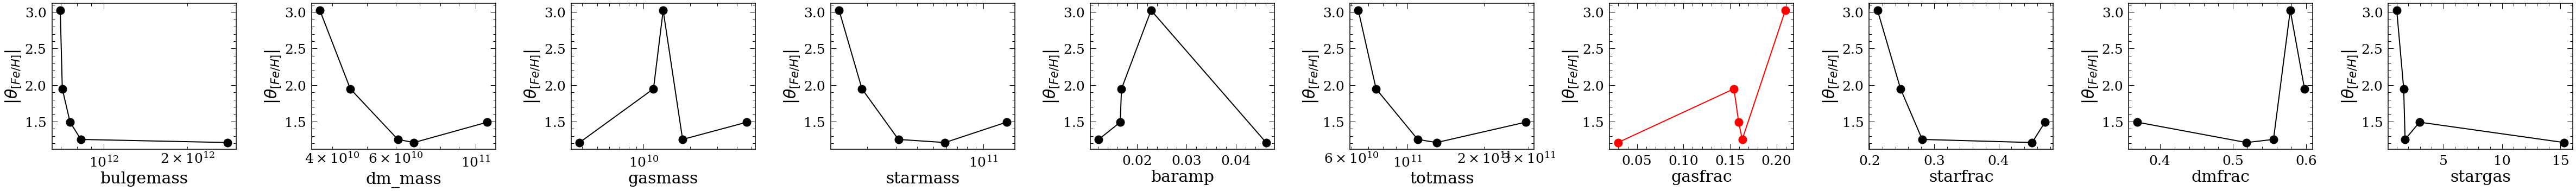

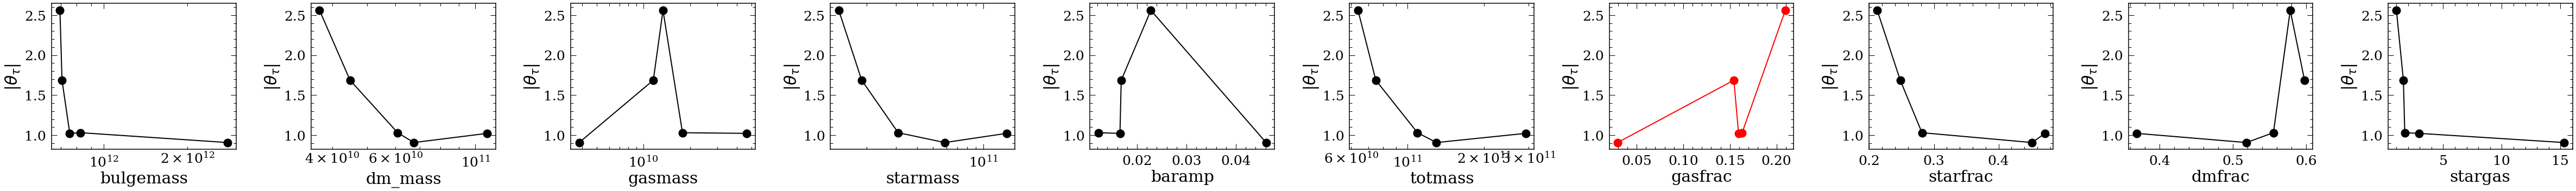

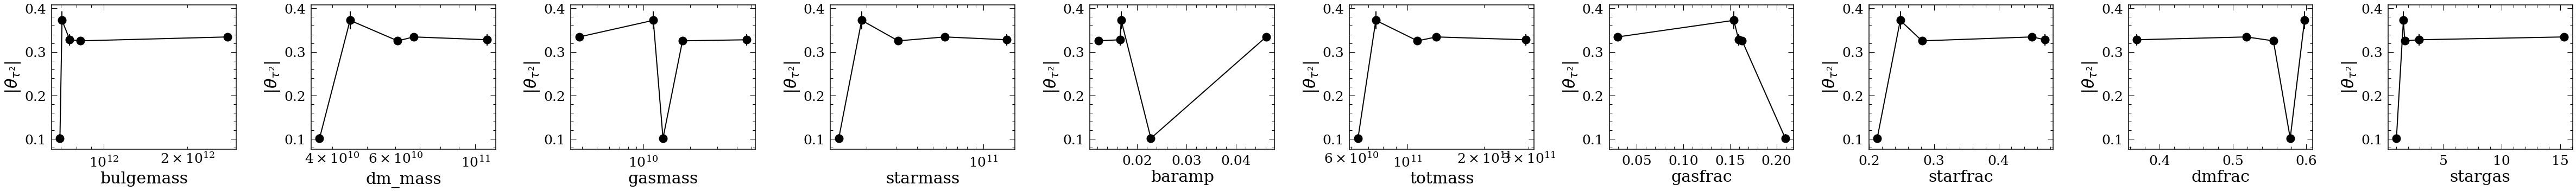

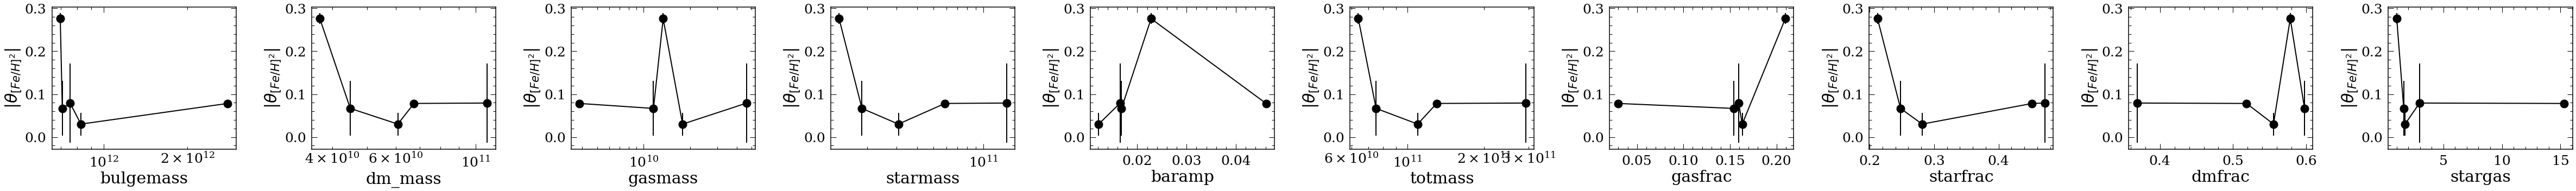

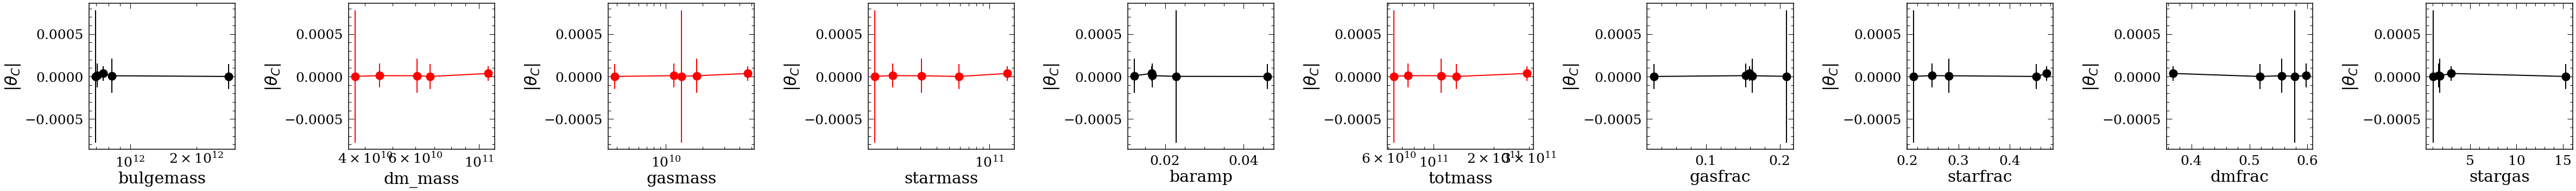

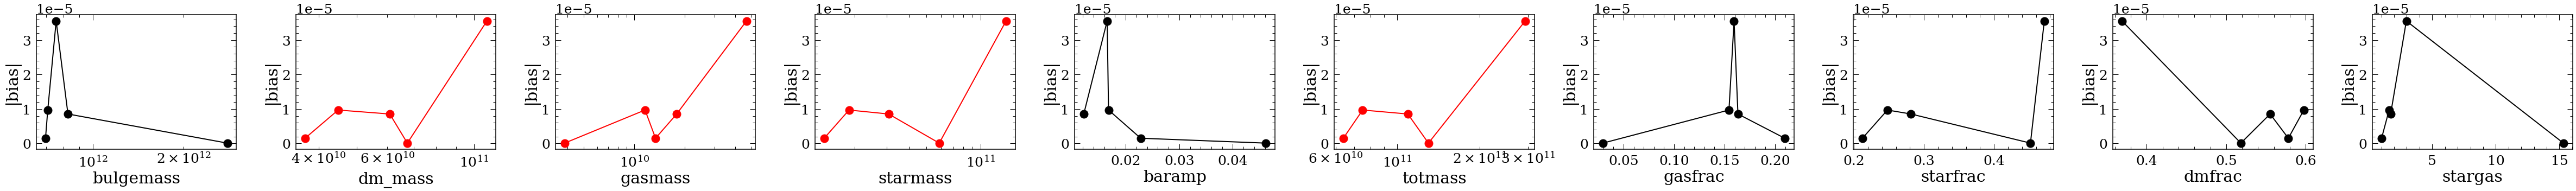

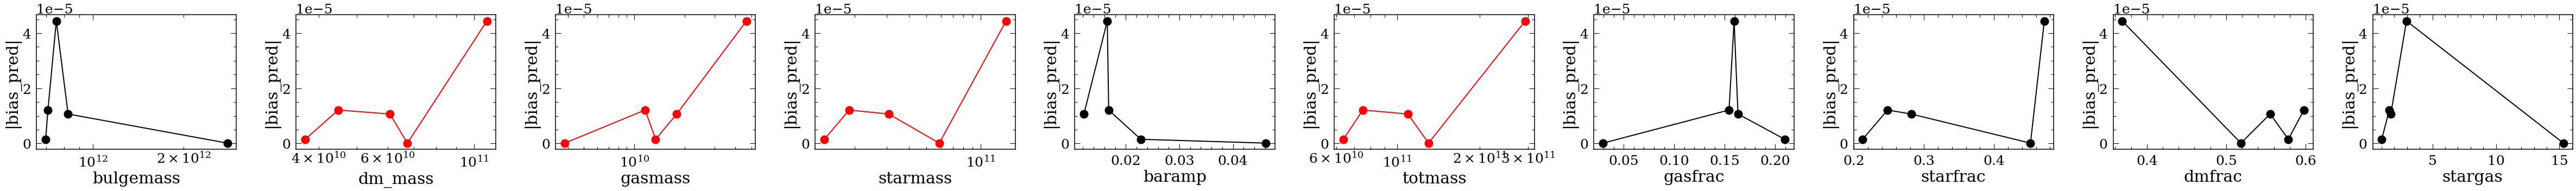

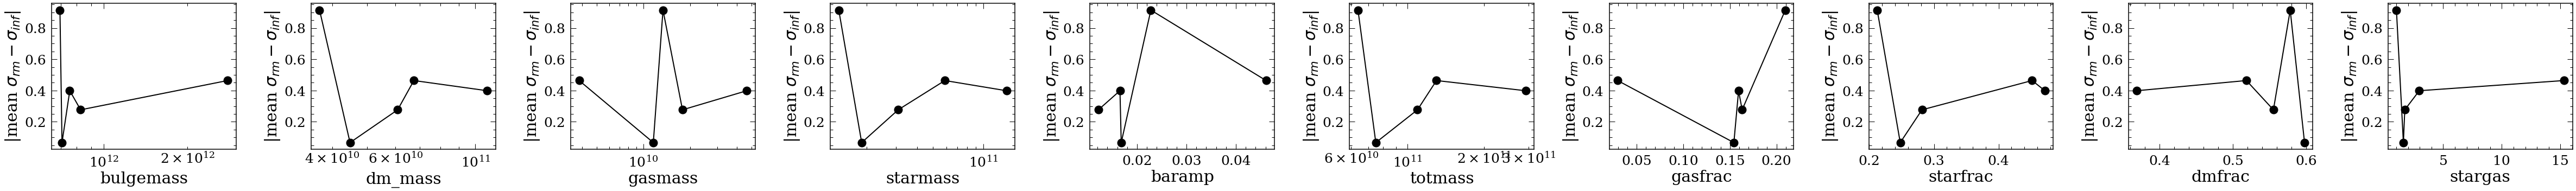

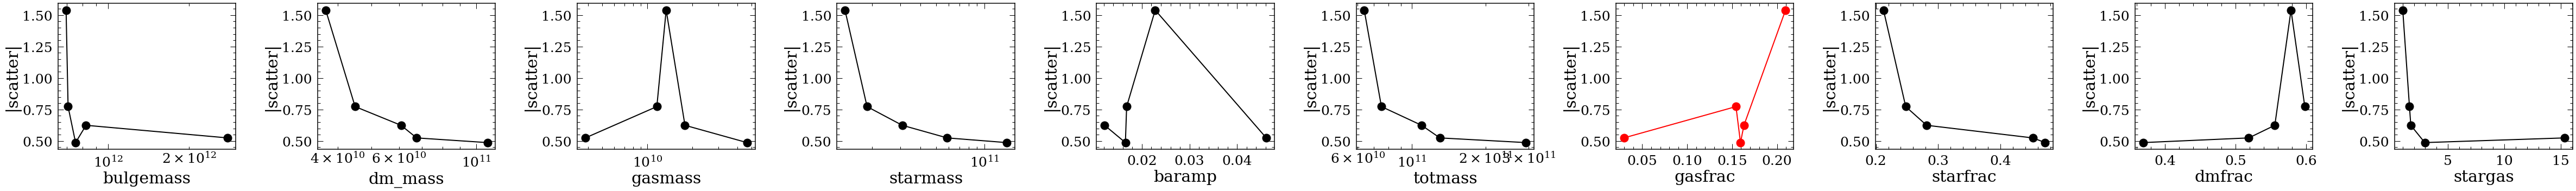

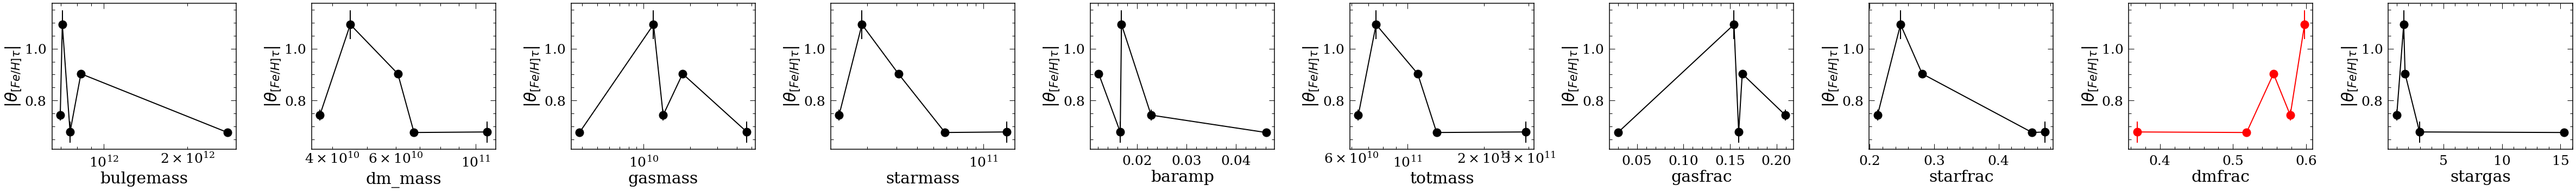

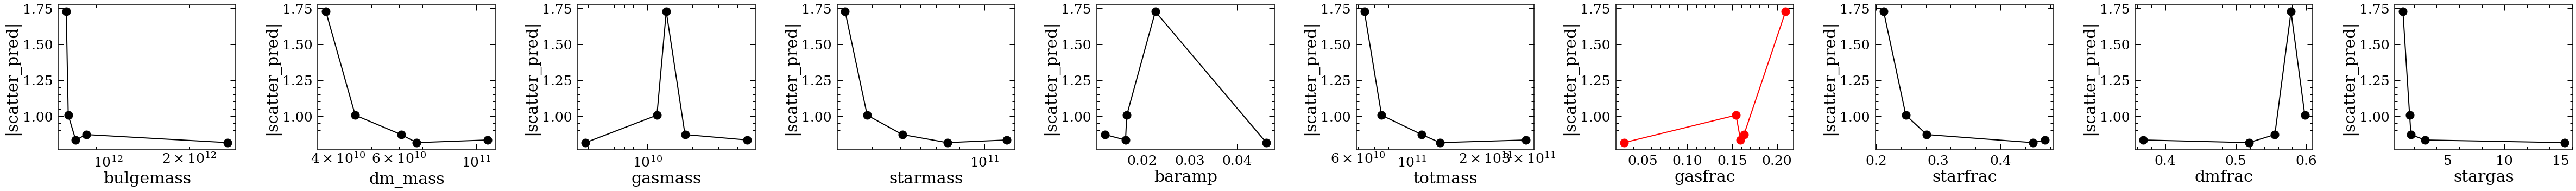

In [103]:
# abs
cols_out = outall['names'].values
sums_out = df_sum.columns

for i in range(len(outall['names'])):
    plt.figure(figsize=(len(sums_out)*6,5))
    df_sing = outall.loc[outall['names']==cols_out[i]]
    #print(df_sing)
    # go into each physical properties
    for j in range(len(sums_out)-1):
        plt.subplot(1,len(sums_out)-1,j+1)
        sum_sing = df_sum[['simname',sums_out[j+1]]]
        # plot the actual plot
        xs = np.zeros(5)
        ys = np.zeros(5)
        ys_err = np.zeros(5)
        for k in range(5):
            xs[k] = sum_sing.loc[sum_sing['simname']==simsnames[k]][sums_out[j+1]]
            ys[k] = abs(df_sing[sum_dic[simsnames[k]]])
            ys_err[k] = df_sing[sum_dic_err[simsnames[k]]]
        xs, ys, ys_err = zip(*sorted(zip(xs, ys, ys_err)))
        pc = np.corrcoef(xs, ys)[0][1]
        if pc>pcthread:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='r', color='r')
        else:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='k', color='k')
        if 'mass' in sums_out[j+1]:
            plt.xscale('log')
        plt.xlabel(sums_out[j+1])
        plt.ylabel("|"+cols_out[i]+"|")
        plt.tight_layout()
        



with g_r

In [104]:
outall = pd.read_pickle('weights_disk_Rg.pkl')
outall

names      w755  w_err755      w708  w_err708      w826  \
0                   $θ_C$ -0.000024  0.000238  0.000015  0.000126  0.000008   
1            $θ_{[Fe/H]}$ -1.041642  0.002117 -1.621186  0.003907 -0.875820   
2                 $θ_{τ}$ -0.692874  0.002647 -1.367193  0.001098 -0.776406   
3               $θ_{R_g}$  0.361657  0.000437  0.219994  0.005000  0.267052   
4          $θ_{[Fe/H]^2}$ -0.053356  0.066841  0.074585  0.080053  0.022443   
5           $θ_{[Fe/H]τ}$  0.475069  0.038512  0.948099  0.085808  0.647095   
6         $θ_{[Fe/H]R_g}$  0.024565  0.005767  0.020183  0.009724  0.071098   
7               $θ_{τ^2}$ -0.279648  0.013748 -0.289767  0.030557 -0.299167   
8              $θ_{R_gτ}$ -0.030283  0.007922  0.035635  0.014225 -0.058890   
9             $θ_{R_g^2}$ -0.048646  0.002444  0.005264  0.003055  0.019562   
10                scatter  0.446997  0.000000  0.672551  0.000000  0.548541   
11                   bias  0.000024  0.000000 -0.000015  0.000000 -0.000008   
12           scatter_pred  0.756992  0.000000  0.897055  0.000000  0.787117   
13              bias_pred  0.000030  0.000000 -0.000019  0.000000 -0.000010   
14  mean $σ_{rm}-σ_{inf}$  0.428986  0.000000  0.165925  0.000000  0.327555   

    w_err826          w279  w_err279          w696  w_err696  
0   0.000126  1.379609e-07  0.000220  7.102892e-07  0.000396  
1   0.001195 -1.030792e+00  0.000251 -2.612159e+00  0.004627  
2   0.000830 -7.942301e-01  0.000174 -2.171598e+00  0.003411  
3   0.000619  1.831745e-01  0.000281  1.864663e-01  0.000479  
4   0.024155  2.453753e-02  0.000909 -6.199739e-01  0.045567  
5   0.005231  4.648497e-01  0.001227 -2.226918e-01  0.078519  
6   0.001163 -3.732038e-02  0.000185 -7.094457e-02  0.001274  
7   0.001947 -3.593227e-01  0.000392 -4.626407e-01  0.036002  
8   0.001848 -9.565044e-02  0.000296 -1.580016e-01  0.000940  
9   0.000700 -2.803409e-02  0.000121  1.583024e-02  0.000461  
10  0.000000  4.747772e-01  0.000000  1.478611e+00  0.000000  
11  0.000000 -1.379607e-07  0.000000 -7.102887e-07  0.000000  
12  0.000000  7.582340e-01  0.000000  1.606379e+00  0.000000  
13  0.000000 -1.724510e-07  0.000000 -7.102889e-07  0.000000  
14  0.000000  4.722265e-01  0.000000 -7.900343e-01  0.000000

/tmp/ipykernel_3420507/2771498907.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
/tmp/ipykernel_3420507/2771498907.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))


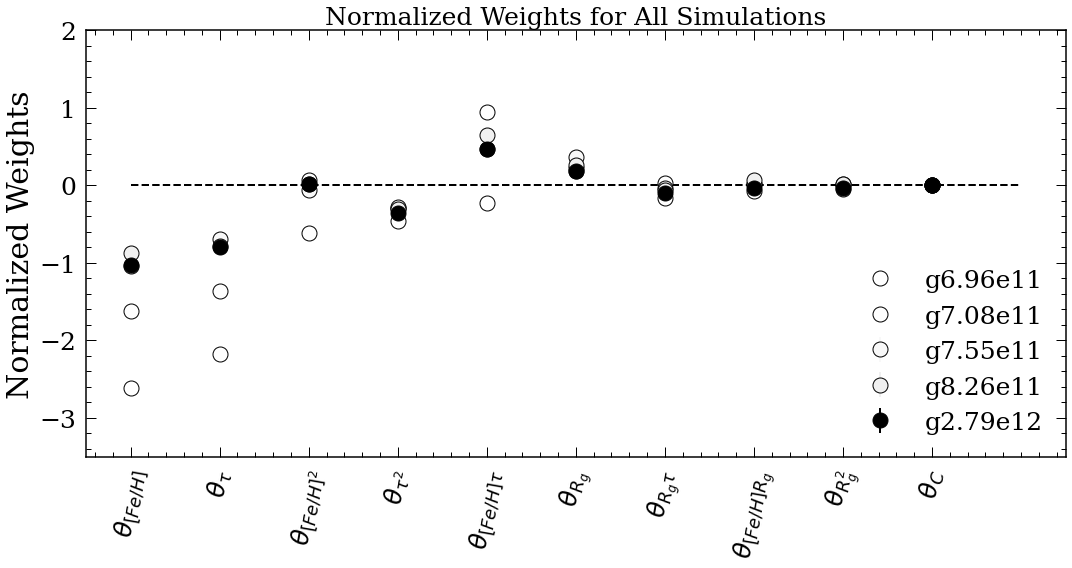

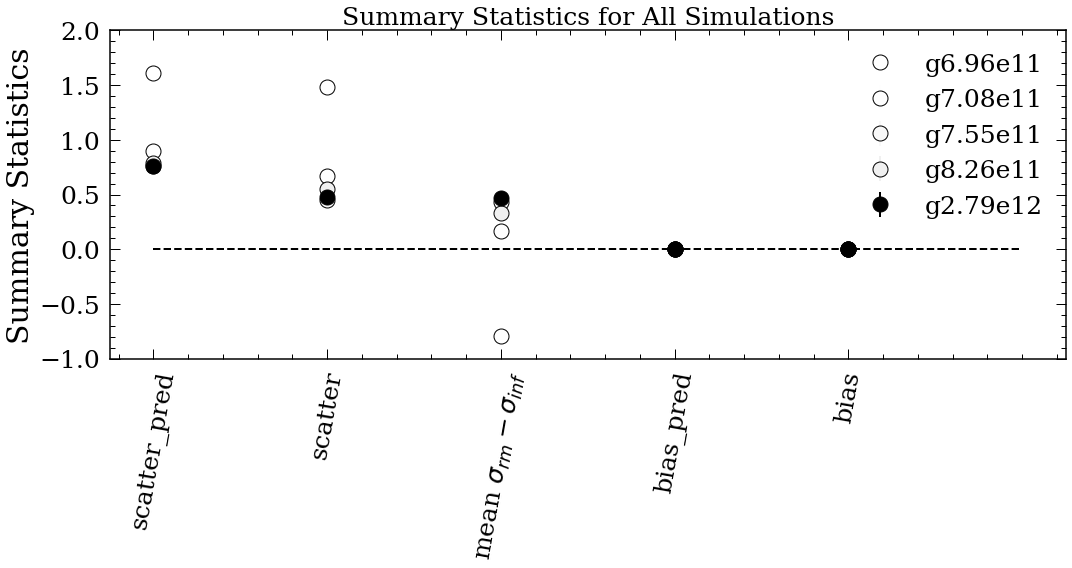

In [105]:
import matplotlib
def getcolor(vrange,cm=plt.cm.get_cmap('binary')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]

bulgemass = sorted(np.array(simsnames, dtype=float))
colors = getcolor(bulgemass)


outall_w = outall.loc[outall['names'].isin(['$θ_{[Fe/H]}$','$θ_{τ}$','$θ_{[Fe/H]τ}$',
                                            '$θ_{R_g}$','$θ_{τ^2}$','$θ_{[Fe/H]^2}$',
                                            '$θ_{R_g^2}$', '$θ_{R_gτ}$',
                                            '$θ_{[Fe/H]R_g}$','$θ_C$'])]
outall_s = outall.loc[outall['names'].isin(['scatter','bias','scatter_pred',
                                            'bias_pred','mean $σ_{rm}-σ_{inf}$'])]

outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
outall_w = outall_w.sort_values(by='absw696').reset_index(drop=True)
outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))
outall_s = outall_s.sort_values(by='absw696').reset_index(drop=True)


        
plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_w)), outall_w['w696'], yerr=outall_w['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w708'], yerr=outall_w['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w755'], yerr=outall_w['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w826'], yerr=outall_w['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w279'], yerr=outall_w['w_err279'], color=colors[4],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_w)],[0,0],'k--')
plt.ylim([-3.5,2])
plt.xticks(range(len(outall_w)), outall_w['names'], rotation=80)
plt.title('Normalized Weights for All Simulations', fontsize=25)
plt.legend(loc=4)
plt.ylabel('Normalized Weights')
plt.tight_layout()


plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_s)), outall_s['w696'], yerr=outall_s['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w708'], yerr=outall_s['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w755'], yerr=outall_s['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w826'], yerr=outall_s['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w279'], yerr=outall_s['w_err279'], color=colors[4],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_s)],[0,0],'k--')
plt.ylim([-1,2])
plt.xticks(range(len(outall_s)), outall_s['names'], rotation=80)
plt.title('Summary Statistics for All Simulations', fontsize=25)
plt.legend(loc=1)
plt.ylabel('Summary Statistics')
plt.tight_layout()




In [106]:
outall = outall.sort_values(by='w755').reset_index(drop=True)

$θ_{[Fe/H]}$
$θ_{τ}$
$θ_{τ^2}$
$θ_{[Fe/H]^2}$
$θ_{R_g^2}$
$θ_{R_gτ}$
$θ_C$
bias
bias_pred
$θ_{[Fe/H]R_g}$
$θ_{R_g}$
mean $σ_{rm}-σ_{inf}$
scatter
$θ_{[Fe/H]τ}$
scatter_pred


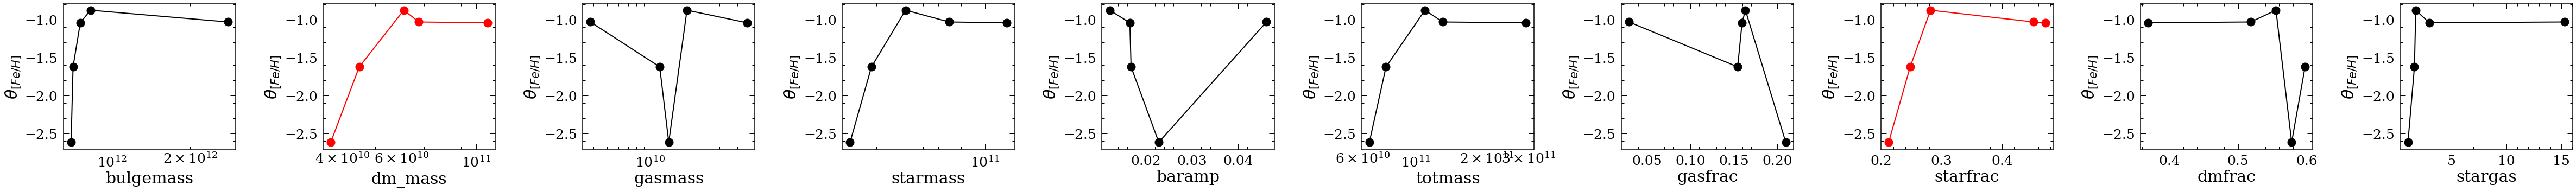

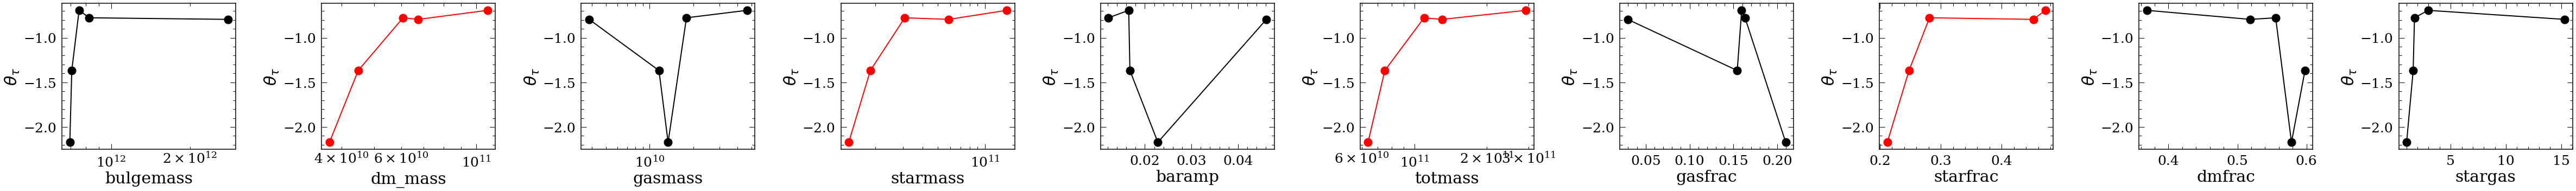

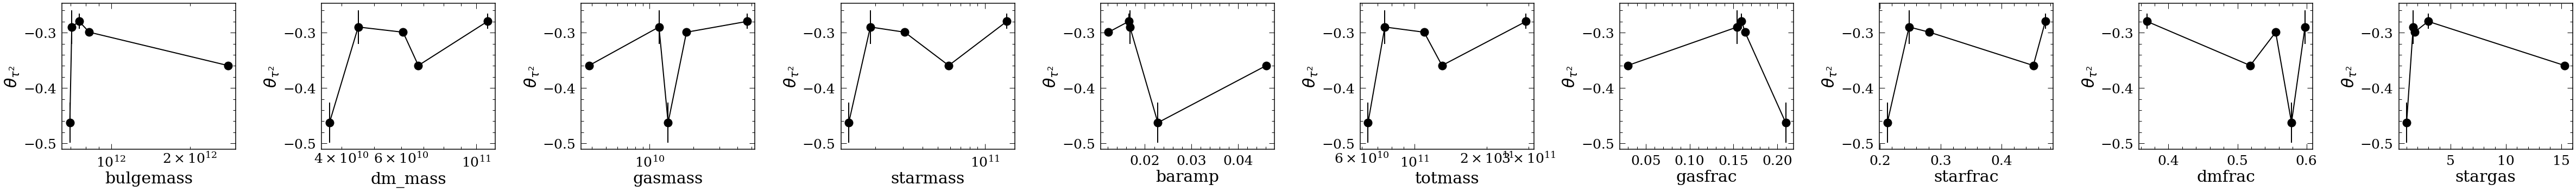

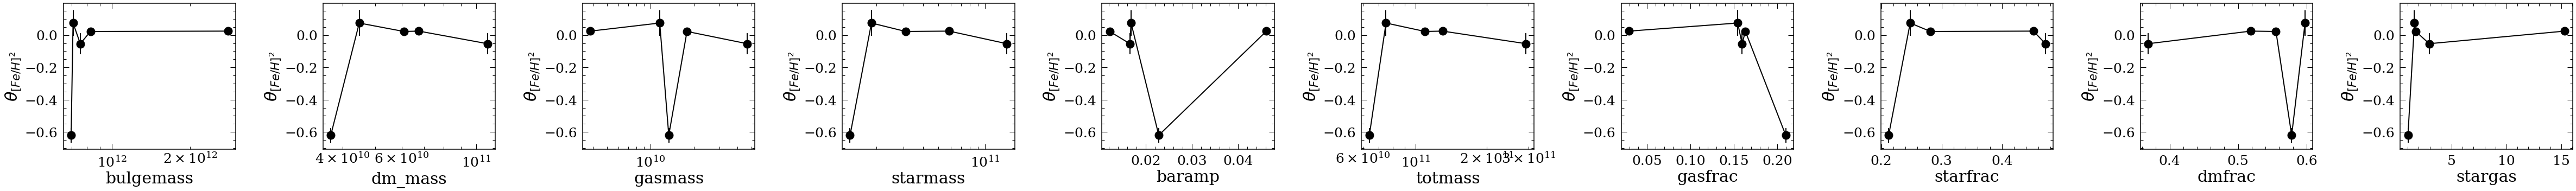

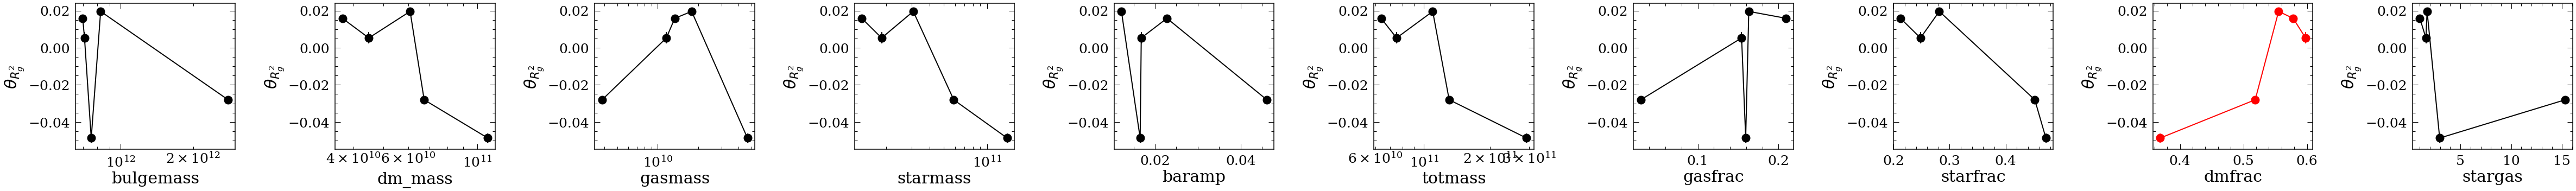

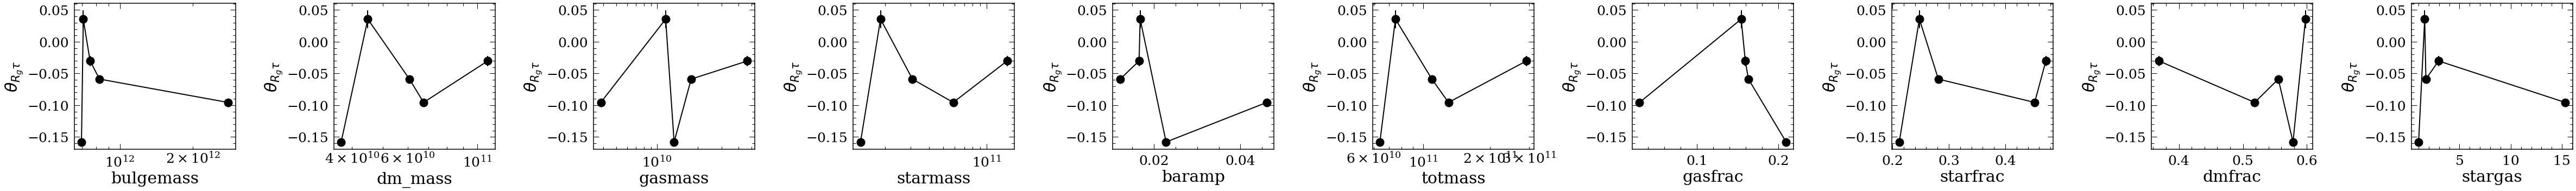

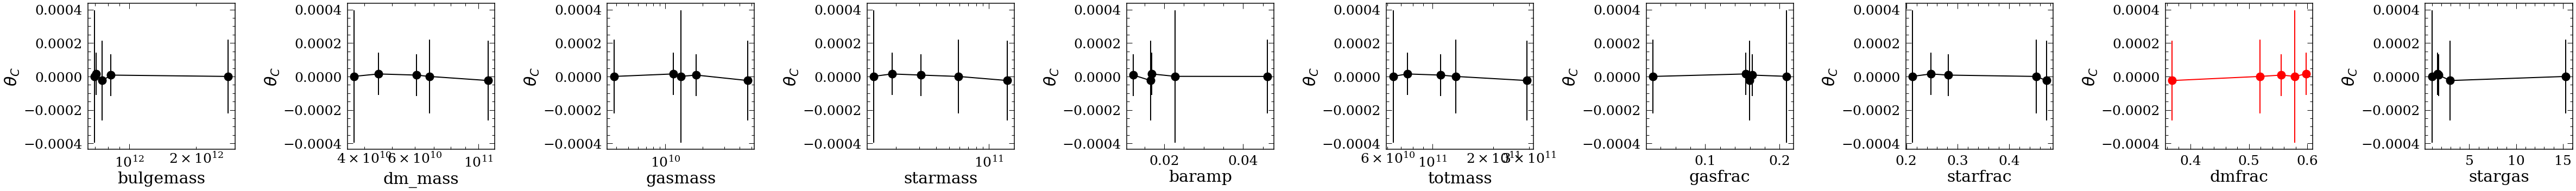

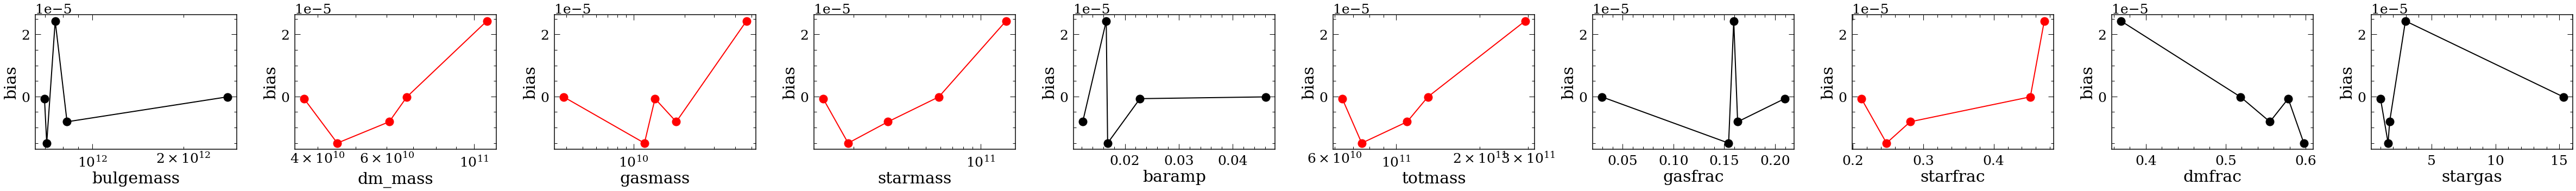

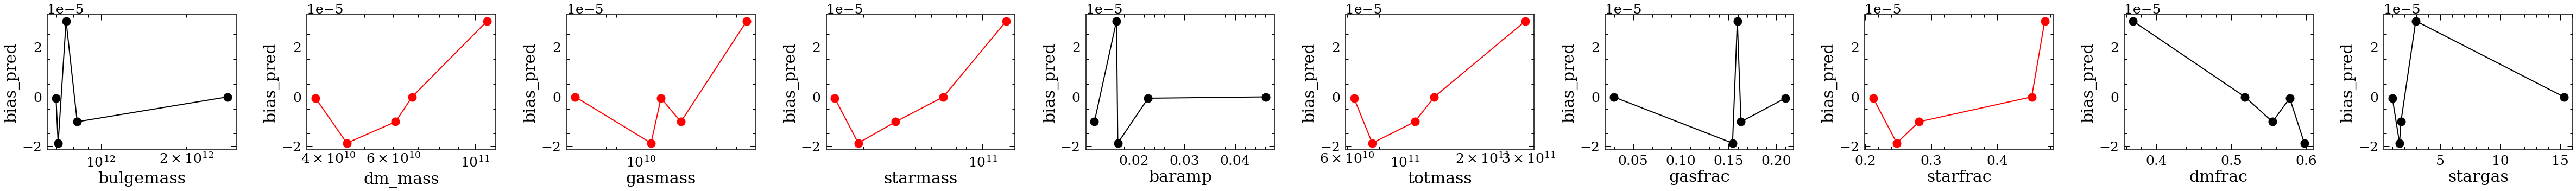

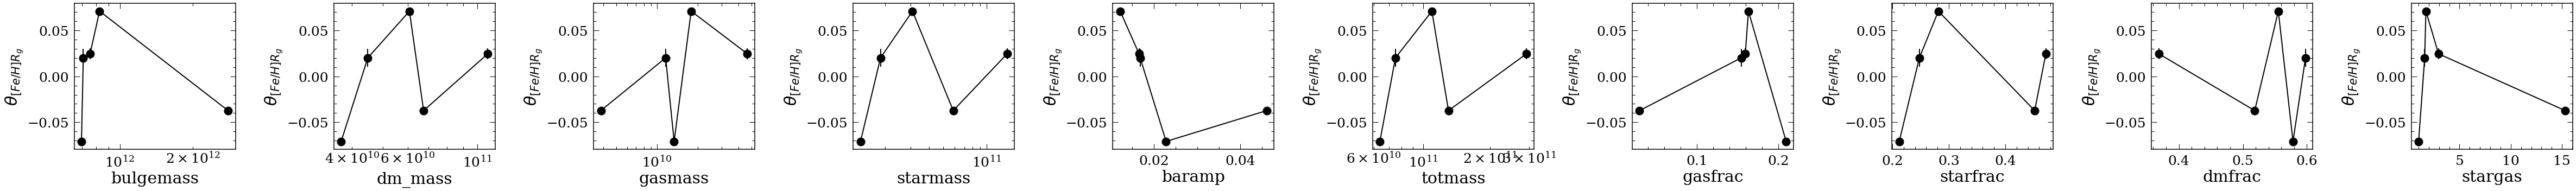

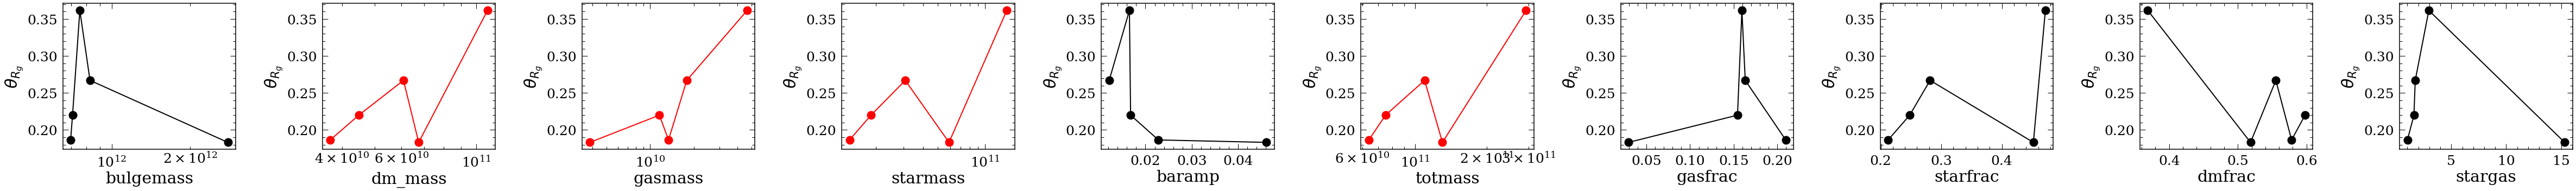

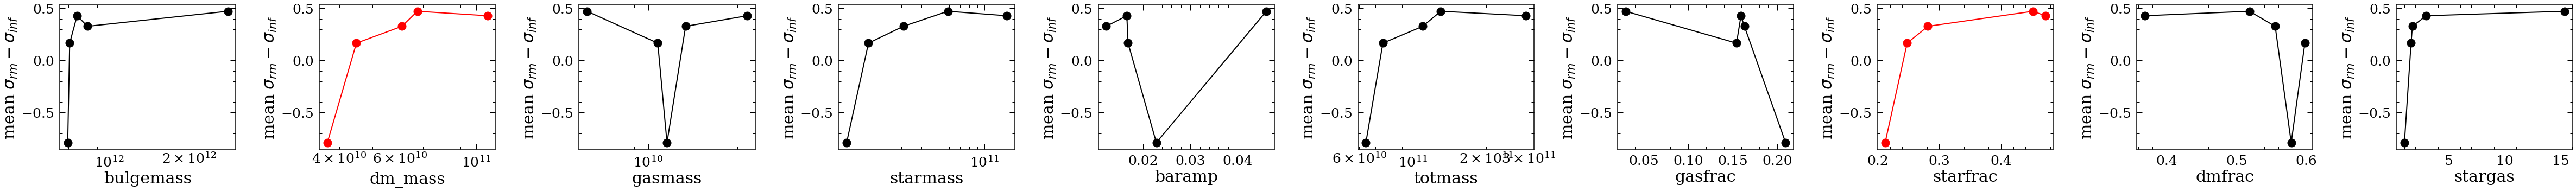

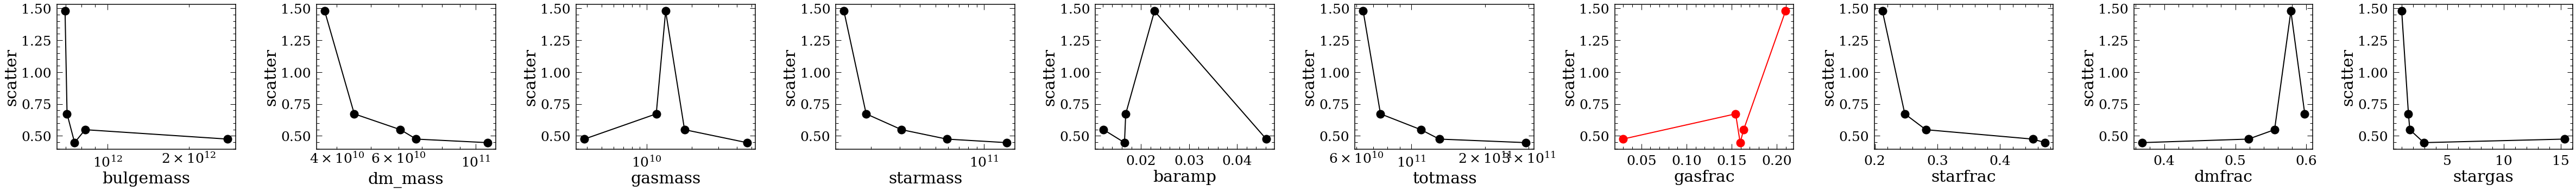

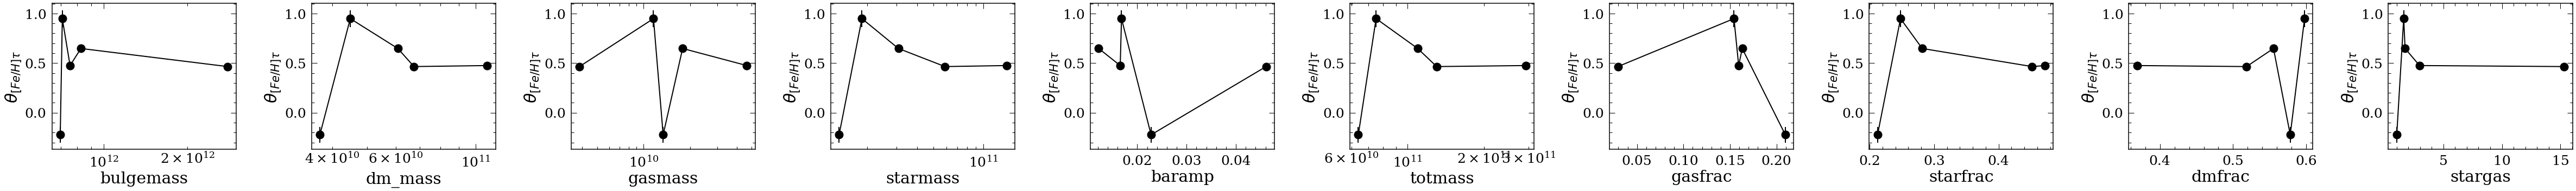

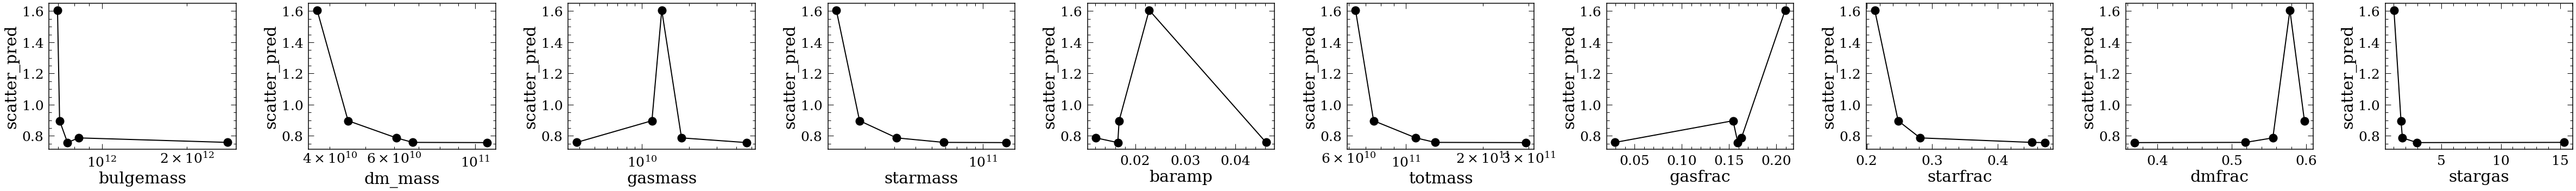

In [107]:

cols_out = outall['names'].values
sums_out = df_sum.columns

for i in range(len(outall['names'])):
    plt.figure(figsize=(len(sums_out)*6,5))
    print(cols_out[i])
    df_sing = outall.loc[outall['names']==cols_out[i]]
    #print(df_sing)
    # go into each physical properties
    for j in range(len(sums_out)-1):
        plt.subplot(1,len(sums_out)-1,j+1)
        sum_sing = df_sum[['simname',sums_out[j+1]]]
        # plot the actual plot
        xs = np.zeros(5)
        ys = np.zeros(5)
        ys_err = np.zeros(5)
        for k in range(5):
            xs[k] = sum_sing.loc[sum_sing['simname']==simsnames[k]][sums_out[j+1]]
            ys[k] = df_sing[sum_dic[simsnames[k]]]
            ys_err[k] = df_sing[sum_dic_err[simsnames[k]]]
        xs, ys, ys_err = zip(*sorted(zip(xs, ys, ys_err)))
        pc = np.corrcoef(xs, ys)[0][1]
        if pc>pcthread:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='r', color='r')
        else:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='k', color='k')
        if 'mass' in sums_out[j+1]:
            plt.xscale('log')
        plt.xlabel(sums_out[j+1])
        plt.ylabel(cols_out[i])
        plt.tight_layout()
        



$θ_{[Fe/H]}$
$θ_{τ}$
$θ_{τ^2}$
$θ_{[Fe/H]^2}$
$θ_{R_g^2}$
$θ_{R_gτ}$
$θ_C$
bias
bias_pred
$θ_{[Fe/H]R_g}$
$θ_{R_g}$
mean $σ_{rm}-σ_{inf}$
scatter
$θ_{[Fe/H]τ}$
scatter_pred


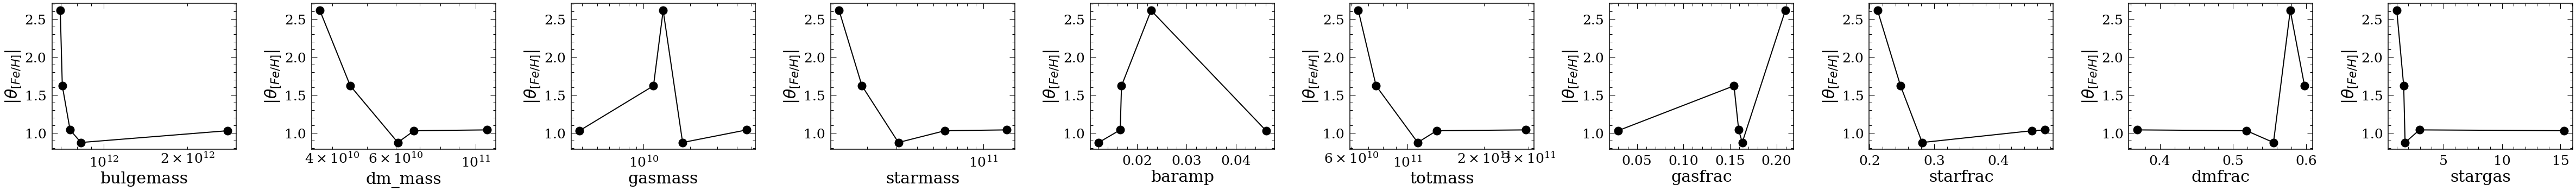

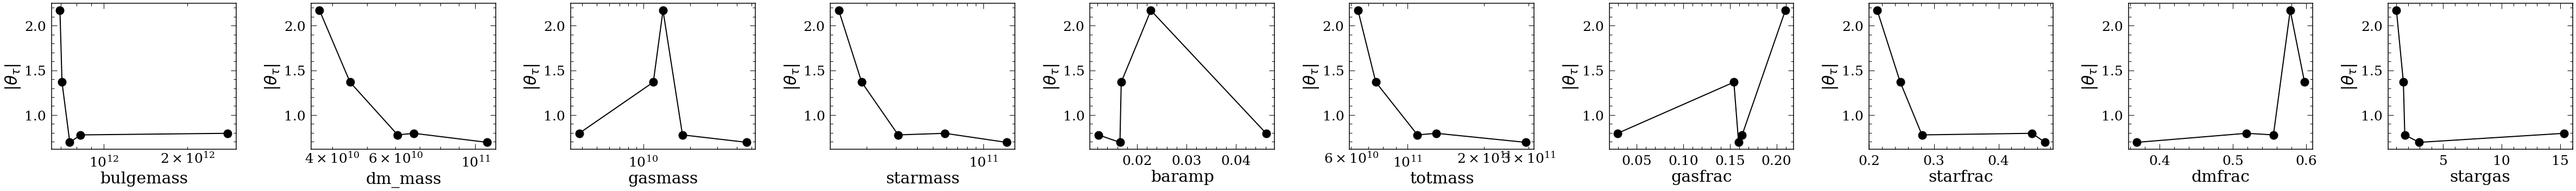

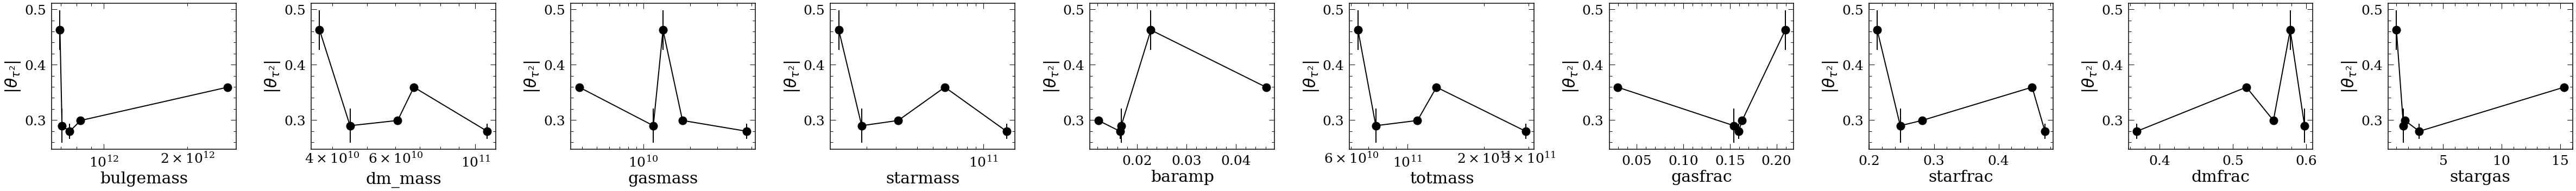

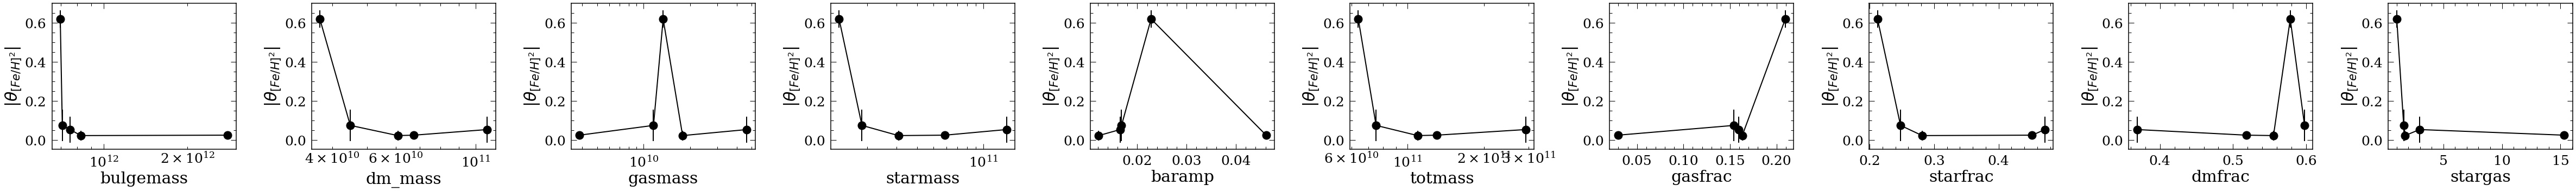

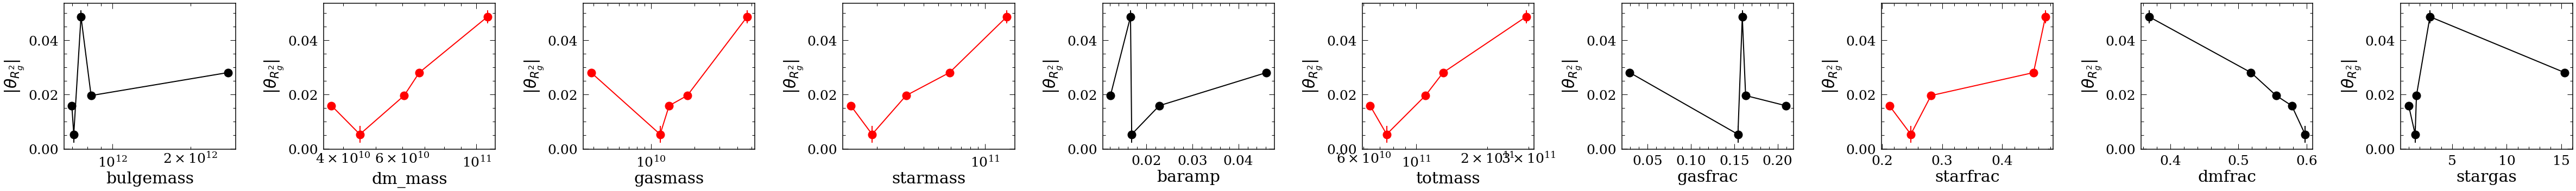

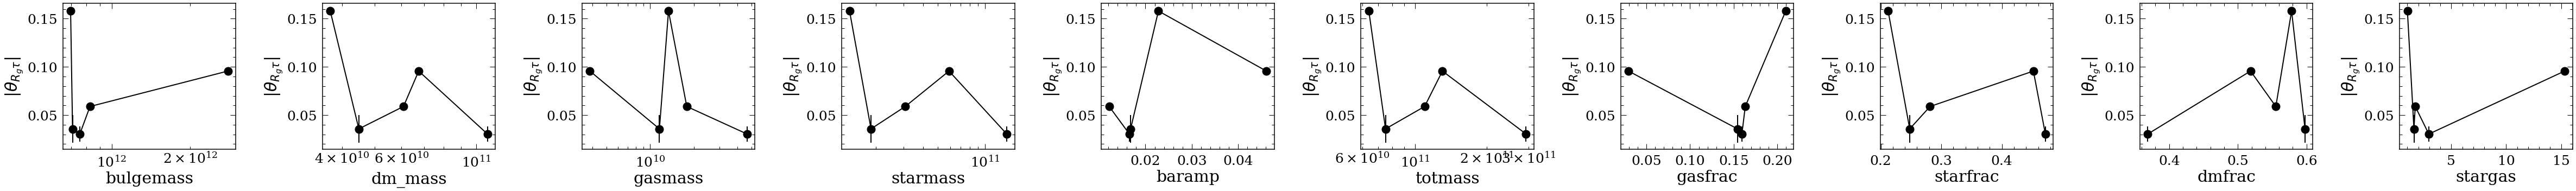

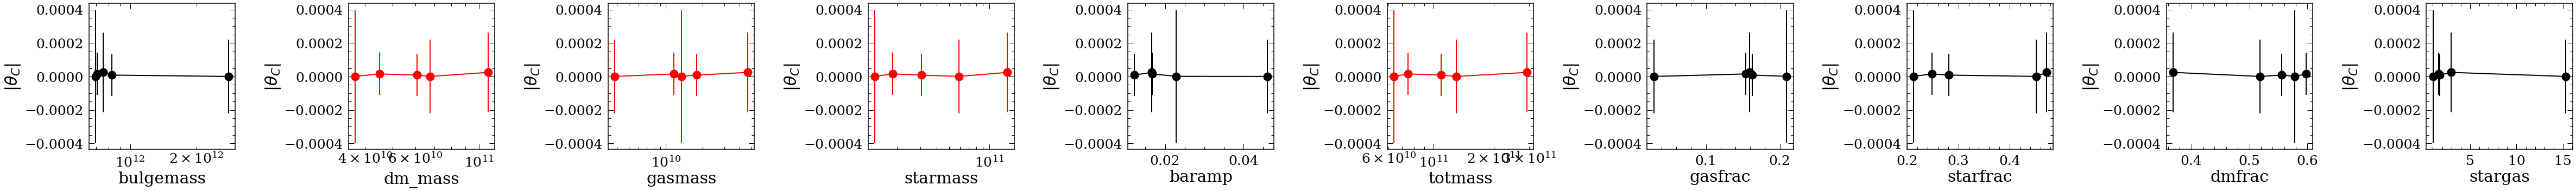

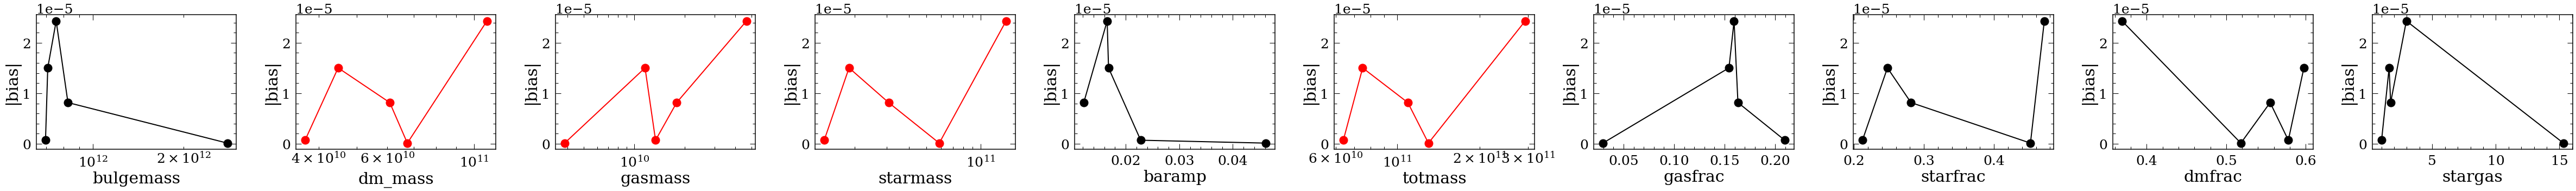

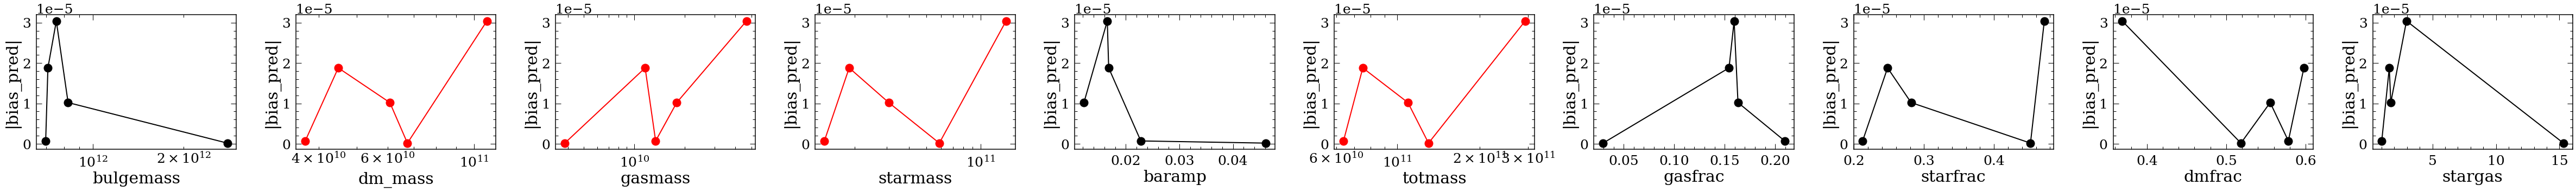

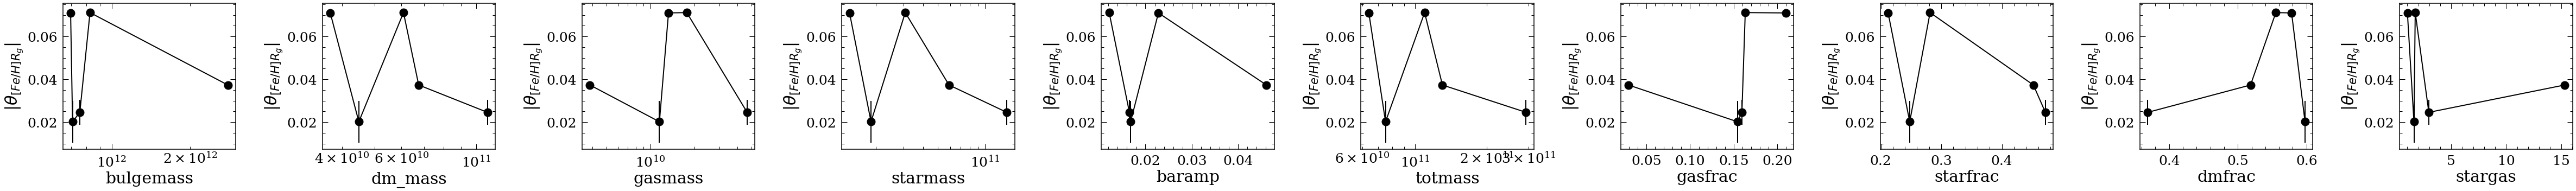

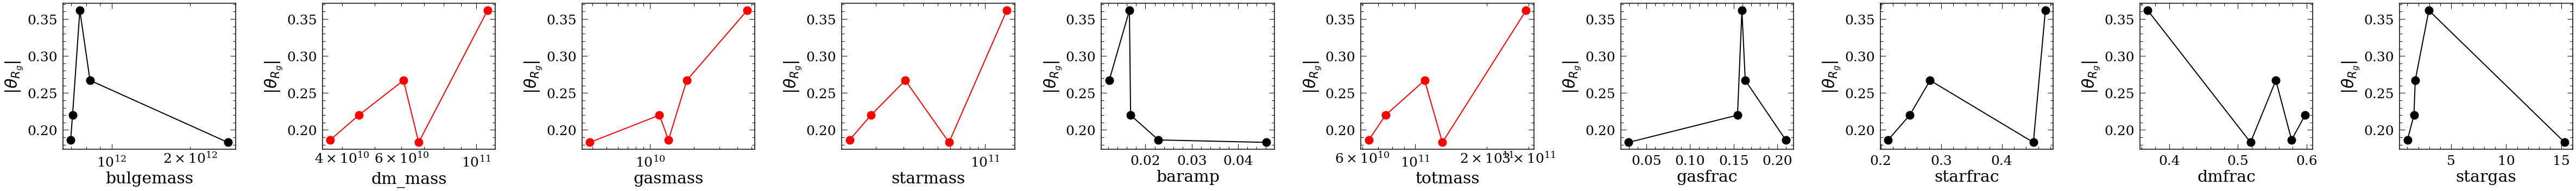

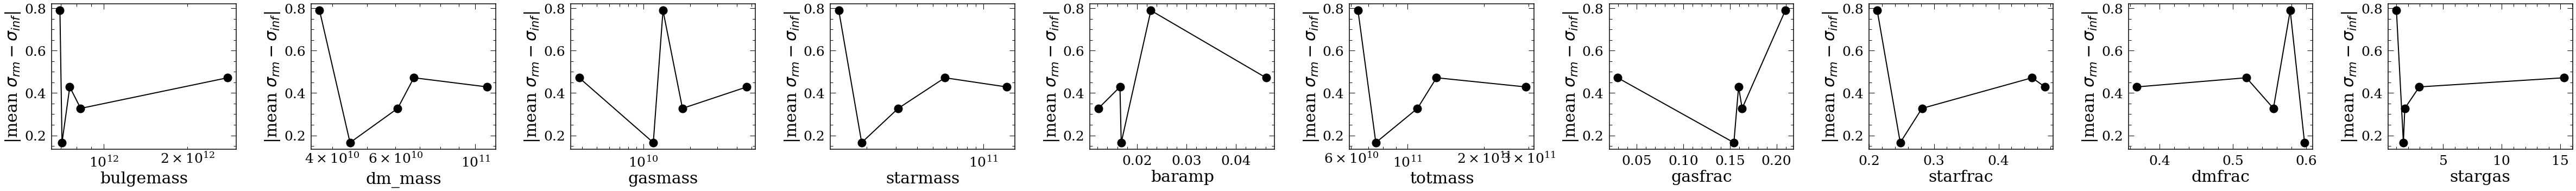

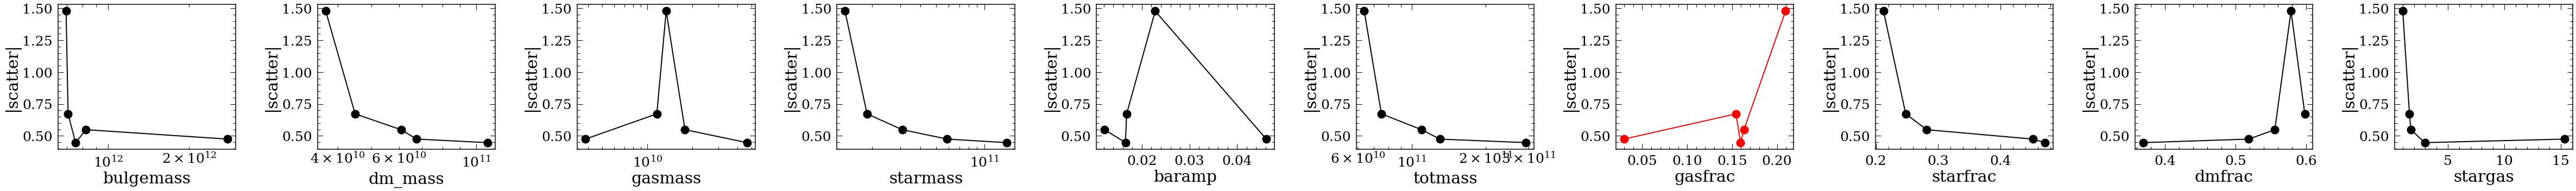

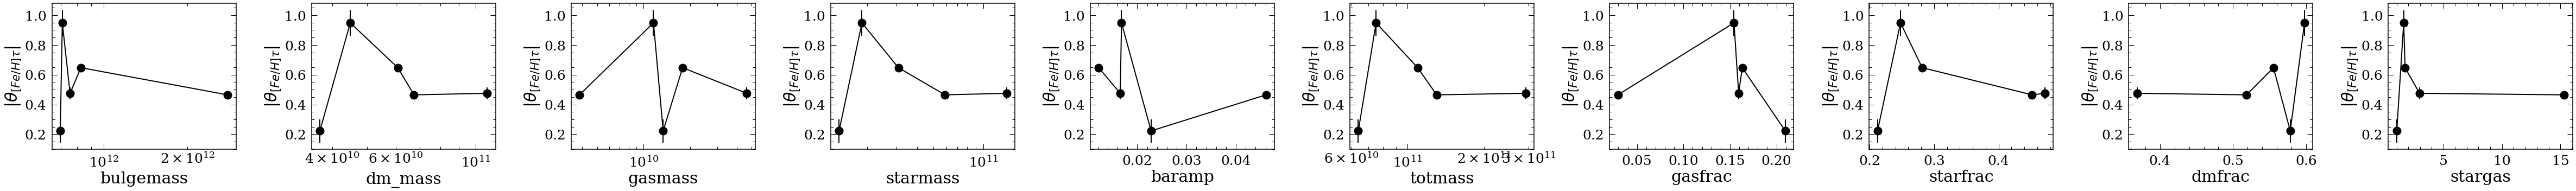

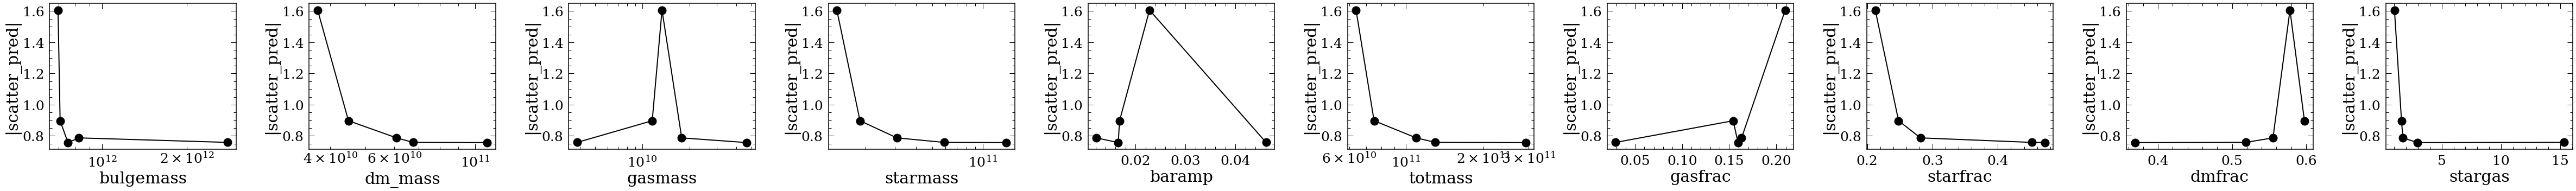

In [108]:
# abs

cols_out = outall['names'].values
sums_out = df_sum.columns

for i in range(len(outall['names'])):
    plt.figure(figsize=(len(sums_out)*6,5))
    print(cols_out[i])
    df_sing = outall.loc[outall['names']==cols_out[i]]
    #print(df_sing)
    # go into each physical properties
    for j in range(len(sums_out)-1):
        plt.subplot(1,len(sums_out)-1,j+1)
        sum_sing = df_sum[['simname',sums_out[j+1]]]
        # plot the actual plot
        xs = np.zeros(5)
        ys = np.zeros(5)
        ys_err = np.zeros(5)
        for k in range(5):
            xs[k] = sum_sing.loc[sum_sing['simname']==simsnames[k]][sums_out[j+1]]
            ys[k] = abs(df_sing[sum_dic[simsnames[k]]])
            ys_err[k] = df_sing[sum_dic_err[simsnames[k]]]
        xs, ys, ys_err = zip(*sorted(zip(xs, ys, ys_err)))
        pc = np.corrcoef(xs, ys)[0][1]
        if pc>pcthread:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='r', color='r')
        else:
            plt.errorbar(xs, ys, yerr=ys_err, 
                         markersize=15, fmt='o-',
                         markeredgecolor='k', color='k')
        if 'mass' in sums_out[j+1]:
            plt.xscale('log')
        plt.xlabel(sums_out[j+1])
        plt.ylabel('|'+cols_out[i]+'|')
        plt.tight_layout()
        


